<a href="https://colab.research.google.com/github/LuppeCh/F1EDA/blob/Graficos-7%2F8%2F9/Exploraci%C3%B3n_de_Datos_Trabajo_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
install.packages("dplyr")
install.packages("ggplot2")
install.packages("gridExtra")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("ggplot2"):
“installation of package ‘ggplot2’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
library(dplyr)
library(ggplot2)
library(tidyr)
library(gridExtra)
library(grid)

In [6]:
wil <- read.csv("F12025-WILLIAMS.csv", header = TRUE, dec = ".", sep = "\t")

In [7]:
head(wil)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,0,0,0,1,0,0.513507,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,0,0,1,1,0,1.449180,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,0,0,2,1,0,2.384850,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,0,0,3,1,0,3.320510,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,0,0,4,1,0,4.256180,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,0,0,5,1,0,5.194280,⋯,0,0,0,0,0,0,0,0,0,0


In [8]:
wil$carId <- "WIL"

In [9]:
tail(wil)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,WIL,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,WIL,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,WIL,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,WIL,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,WIL,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,WIL,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


Observamos que lapNum tiene un valor mayor al esperado (4), ya que arranca a contabilizar las vueltas desde 0, por lo que el lapNum = 5 corresponderia a la vuelta 6. Además observamos que los valores de muchas variables toman el valor "-1", lo cual es inconsistente en algunas variables como "lap_distance", por lo que aunque debemos eliminar todos los registros de esta vuelta, vamos a realizar un breve análisis que nos permita comprender que sucedió.

In [10]:
wil <- wil %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

Para trabajar más cómodos, decidimos eliminar todas aquellas columnas que no vamos a utilizar ni ahora ni a futuro.

In [11]:
inconsistencia <- wil %>%

  select(where(is.numeric)) %>%

  summarise(
    across(
      everything(),
      ~ sum(. == -1, na.rm = TRUE)
    )
  )

inconsistencia

lapNum,lap_time,lap_distance,lap_time_invalid,binIndex,velocity_X,velocity_Y,velocity_Z
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,3237,3237,3237,0,3237,3237,3237


Creamos un pequeño dataset que nos permite ver cuantas de las variables númericas existentes en nuestro dataset tienen un valor igual a "-1". Al imprimirla observamos que 6 de las 8 variables tienen 3237 registros de este tipo. Sospechamos que cuando una de estas variables toma el valor -1, las otras 5 también.

In [12]:
sospechosas <- c(
  "lap_time",
  "lap_distance",
  "lap_time_invalid",
  "velocity_X",
  "velocity_Y",
  "velocity_Z"
)


conteo_sospechosas <- wil %>%
  summarise(
    cant_sospechosas = sum(if_all(all_of(sospechosas), ~ . == -1), na.rm = TRUE)
  ) %>%
  pull()

conteo_sospechosas

[1] 3237

Se confirma nuestra teoría. Además, por lo leído en el archivo de especificaciones de EA SPORTS F1, este valor suele significar que no se ha cruzado la línea de meta, lo que puede indicar que estos valores pertenezcan a:

1. Una vuelta de calentamiento.
2. Los metros que sigue recorriendo el automóvil antes de frenar, luego de cruzar la meta.

In [13]:
final_valido <- wil %>%
  filter(lapNum == 5) %>%
  group_by(lap_time_invalid) %>%
  summarise(
    N_Registros = n(),
    .groups = 'drop'
  )

  final_valido

lap_time_invalid,N_Registros
<int>,<int>
-1,3237
0,1057


Confirmamos que todos estos valores pertenecen a la vuelta 6 (lapNum = 5), lo que indicaria que todos estos registros se deben a la razón 2.

In [14]:
wil <- wil %>%
  filter(lapNum < 5)

Borramos esta vuelta.

In [15]:
mcl <- read.csv("F12025-MCLAREN.csv", header = TRUE, dec = ".", sep = "\t")

In [16]:
head(mcl)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,21,0,0,1,21,0.40625,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,21,0,1,1,21,1.41602,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,21,0,2,1,21,2.42578,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,21,0,3,1,21,3.43555,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,21,0,4,1,21,4.44531,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,21,0,5,1,21,5.45703,⋯,0,0,0,0,0,0,0,0,0,0


In [17]:
mcl$carId <- "MCL"

In [18]:
mcl$lapNum <- mcl$lapNum - 21

In [19]:
tail(mcl)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,MCL,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,MCL,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,MCL,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,MCL,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,MCL,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,MCL,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [20]:
mcl <- mcl %>%
  filter(lapNum < 5)

In [21]:
mcl <- mcl %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [22]:
red <- read.csv("F12025-REDBULL.csv", header = TRUE, dec = ".", sep = "\t")

In [23]:
head(red)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,16,0,0,1,16,2.81250,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,16,0,1,1,16,2.81250,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,16,0,2,1,16,2.81250,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,16,0,3,1,16,3.82617,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,16,0,4,1,16,4.83984,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,16,0,5,1,16,5.85352,⋯,0,0,0,0,0,0,0,0,0,0


In [24]:
red$carId <-"RED"

In [25]:
red$lapNum <- red$lapNum - 16

In [26]:
tail(red)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,RED,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,RED,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,RED,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,RED,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,RED,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,RED,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [27]:
red <- red %>%
  filter(lapNum < 5)

In [28]:
red <- red %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [29]:
alp <- read.csv("F12025-ALPINE.csv", header = TRUE, dec = ".", sep = "\t")

In [30]:
head(alp)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,10,0,0,1,10,1.63281,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,10,0,1,1,10,1.63281,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,10,0,2,1,10,2.62500,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,10,0,3,1,10,3.61719,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,10,0,4,1,10,4.60938,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,10,0,5,1,10,5.60156,⋯,0,0,0,0,0,0,0,0,0,0


In [31]:
alp$carId <- "ALP"

In [32]:
alp$lapNum <- alp$lapNum - 10

In [33]:
tail(alp)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
30053,ALP,Interlagos,4294,6,6,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30054,ALP,Interlagos,4294,6,6,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30055,ALP,Interlagos,4294,6,6,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30056,ALP,Interlagos,4294,6,6,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30057,ALP,Interlagos,4294,6,6,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30058,ALP,Interlagos,4294,6,6,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [34]:
alp <- alp %>%
  filter(lapNum < 5)

In [35]:
alp <- alp %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [36]:
mer <- read.csv("F12025-MERCEDES.csv", header = TRUE, dec = ".", sep = "\t")

In [37]:
head(mer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,5,0,0,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,5,0,1,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,5,0,2,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,5,0,3,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,5,0,4,1,5,4.41357,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,5,0,5,1,5,5.48145,⋯,0,0,0,0,0,0,0,0,0,0


In [38]:
mer$carId <-"MER"

In [39]:
mer$lapNum <- mer$lapNum - 5

In [40]:
tail(mer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,MER,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,MER,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,MER,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,MER,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,MER,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,MER,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [41]:
mer <- mer %>%
  filter(lapNum < 5)

In [42]:
mer <- mer %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [43]:
mer <- mer %>%
  mutate(
    sector = case_when(
      binIndex >= 0 & binIndex <= 1430 ~ "S1",
      binIndex >= 1431 & binIndex <= 2861 ~ "S2",
      binIndex >= 2862 & binIndex <= 4293 ~ "S3",
    ))

In [44]:
fer <- read.csv("F12025-FERRARI.csv", header = TRUE, dec = ".", sep = "\t")

In [45]:
head(fer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,31,0,0,1,31,0.93750,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,31,0,1,1,31,1.80313,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,31,0,2,1,31,2.66875,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,31,0,3,1,31,3.53438,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,31,0,4,1,31,4.40000,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,31,0,5,1,31,5.26562,⋯,0,0,0,0,0,0,0,0,0,0


In [46]:
fer$carId <- "FER"

In [47]:
fer$lapNum <- fer$lapNum - 31

In [48]:
tail(fer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
21465,FER,Interlagos,4294,4,4,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21466,FER,Interlagos,4294,4,4,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21467,FER,Interlagos,4294,4,4,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21468,FER,Interlagos,4294,4,4,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21469,FER,Interlagos,4294,4,4,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21470,FER,Interlagos,4294,4,4,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


En este caso si tenemos la cantidad correcta de vueltas, pero como podemos ver hay muchisimos valores "-1", por lo que debemos borrar esta vuelta y generarla de manera artificial.

In [49]:
fer <- fer %>%
  filter(lapNum < 4)

In [50]:
fer <- fer %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [51]:
vueltas_anuladas_fer <- fer %>%
  group_by(lapNum) %>%
  summarise(lap_time_invalid = max(lap_time_invalid))

Para generar de forma artificial la quinta vuelta, debemos realizarlo promediando los valores de las vueltas validas, por lo que visualizamos cuales son (las que tienen lap_time_valid = 0)

In [52]:
vueltas_anuladas_fer

lapNum,lap_time_invalid
<dbl>,<int>
0,0
1,1
2,1
3,0


Solamente podemos trabajar con la vuelta 1 y 4.

In [53]:
vueltas_validas <- fer %>%
  filter(lapNum %in% c(0, 3))

In [54]:
vuelta_5 <- vueltas_validas %>%
  group_by(binIndex) %>%
  summarise(
    lap_distance = mean(lap_distance, na.rm = TRUE),
    lap_time = mean(lap_time, na.rm = TRUE),
    velocity_X = mean(velocity_X, na.rm = TRUE),
    velocity_Y = mean(velocity_Y, na.rm = TRUE),
    velocity_Z = mean(velocity_Z, na.rm = TRUE),

    carId = "FER",
    lap_time_invalid = 0
  ) %>%

  ungroup()%>%

  mutate(
    lapNum = 4
  )

Las filtramos en el dataset "vueltas_validas" y construimos la "vuelta_5" calculando los promedios en la variables indicadas, despues le pasamos el valor del id, que la vuelta es valida y que es la número 5.

In [55]:
fer <- bind_rows(fer, vuelta_5)

La agregamos a nuestro dataset de ferrari.

In [56]:
telemetria <- bind_rows(fer, red, mcl, mer, alp, wil)

Únimos los 6 datasets en uno único.

In [57]:
telemetria <- telemetria %>%
  mutate(
    sector = case_when(
      binIndex >= 0 & binIndex <= 1430 ~ "S1",
      binIndex >= 1431 & binIndex <= 2861 ~ "S2",
      binIndex >= 2862 & binIndex <= 4293 ~ "S3",
    ),
    track_lenght = 4294
    )

Creamos la columna sector, indicando el valor que toma según el binIndex.

In [58]:
telemetria <- telemetria %>%
  mutate(
    velocity_total_ms = sqrt(
      velocity_X^2 +
      velocity_Y^2 +
      velocity_Z^2
    ),

    velocidad = velocity_total_ms * 3.6
  )

telemetria <- telemetria %>%
  select(-velocity_total_ms)

In [59]:
inconsistencia_global <- telemetria %>%

  select(where(is.numeric)) %>%

  summarise(
    across(
      everything(),
      ~ sum(. == -1, na.rm = TRUE)
    )
  )

inconsistencia_global

lapNum,lap_time,lap_distance,lap_time_invalid,binIndex,velocity_X,velocity_Y,velocity_Z,track_lenght,velocidad
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0


In [60]:
telemetria <- telemetria %>%
  mutate(lap_number = lapNum + 1)

In [61]:
registros <- nrow(telemetria)
print(paste("cant. registros:", registros))

escuderias <- unique(telemetria$carId)
print(escuderias)

cant_lap <- unique(telemetria$lapNum)
print(cant_lap)

cant_lap <- unique(telemetria$lap_number)
print(cant_lap)

any(is.na(telemetria))

[1] "cant. registros: 128820"
[1] "FER" "RED" "MCL" "MER" "ALP" "WIL"
[1] 0 1 2 3 4
[1] 1 2 3 4 5


[1] FALSE

In [62]:
options(repr.plot.width = 20, repr.plot.height = 14)

# ETAPA 2A

A continuación, elaboramos un gráfico que muestra el tiempo por vuelta de cada escudería.

##Actividad 2 (Grafico 1)

Elabore un gráfico que muestre el tiempo por vuelta para cada uno de los vehículos. En el eje de las abscisas (X), se representarán las vueltas, mientras que en el eje de las ordenadas (Y) se plasmará el tiempo empleado por cada vehículo en cada vuelta.

In [71]:
lap_times_summary <- telemetria %>%
  group_by(carId, lap_number) %>%
  summarise(total_lap_time = max(lap_time, na.rm = TRUE), .groups = 'drop')

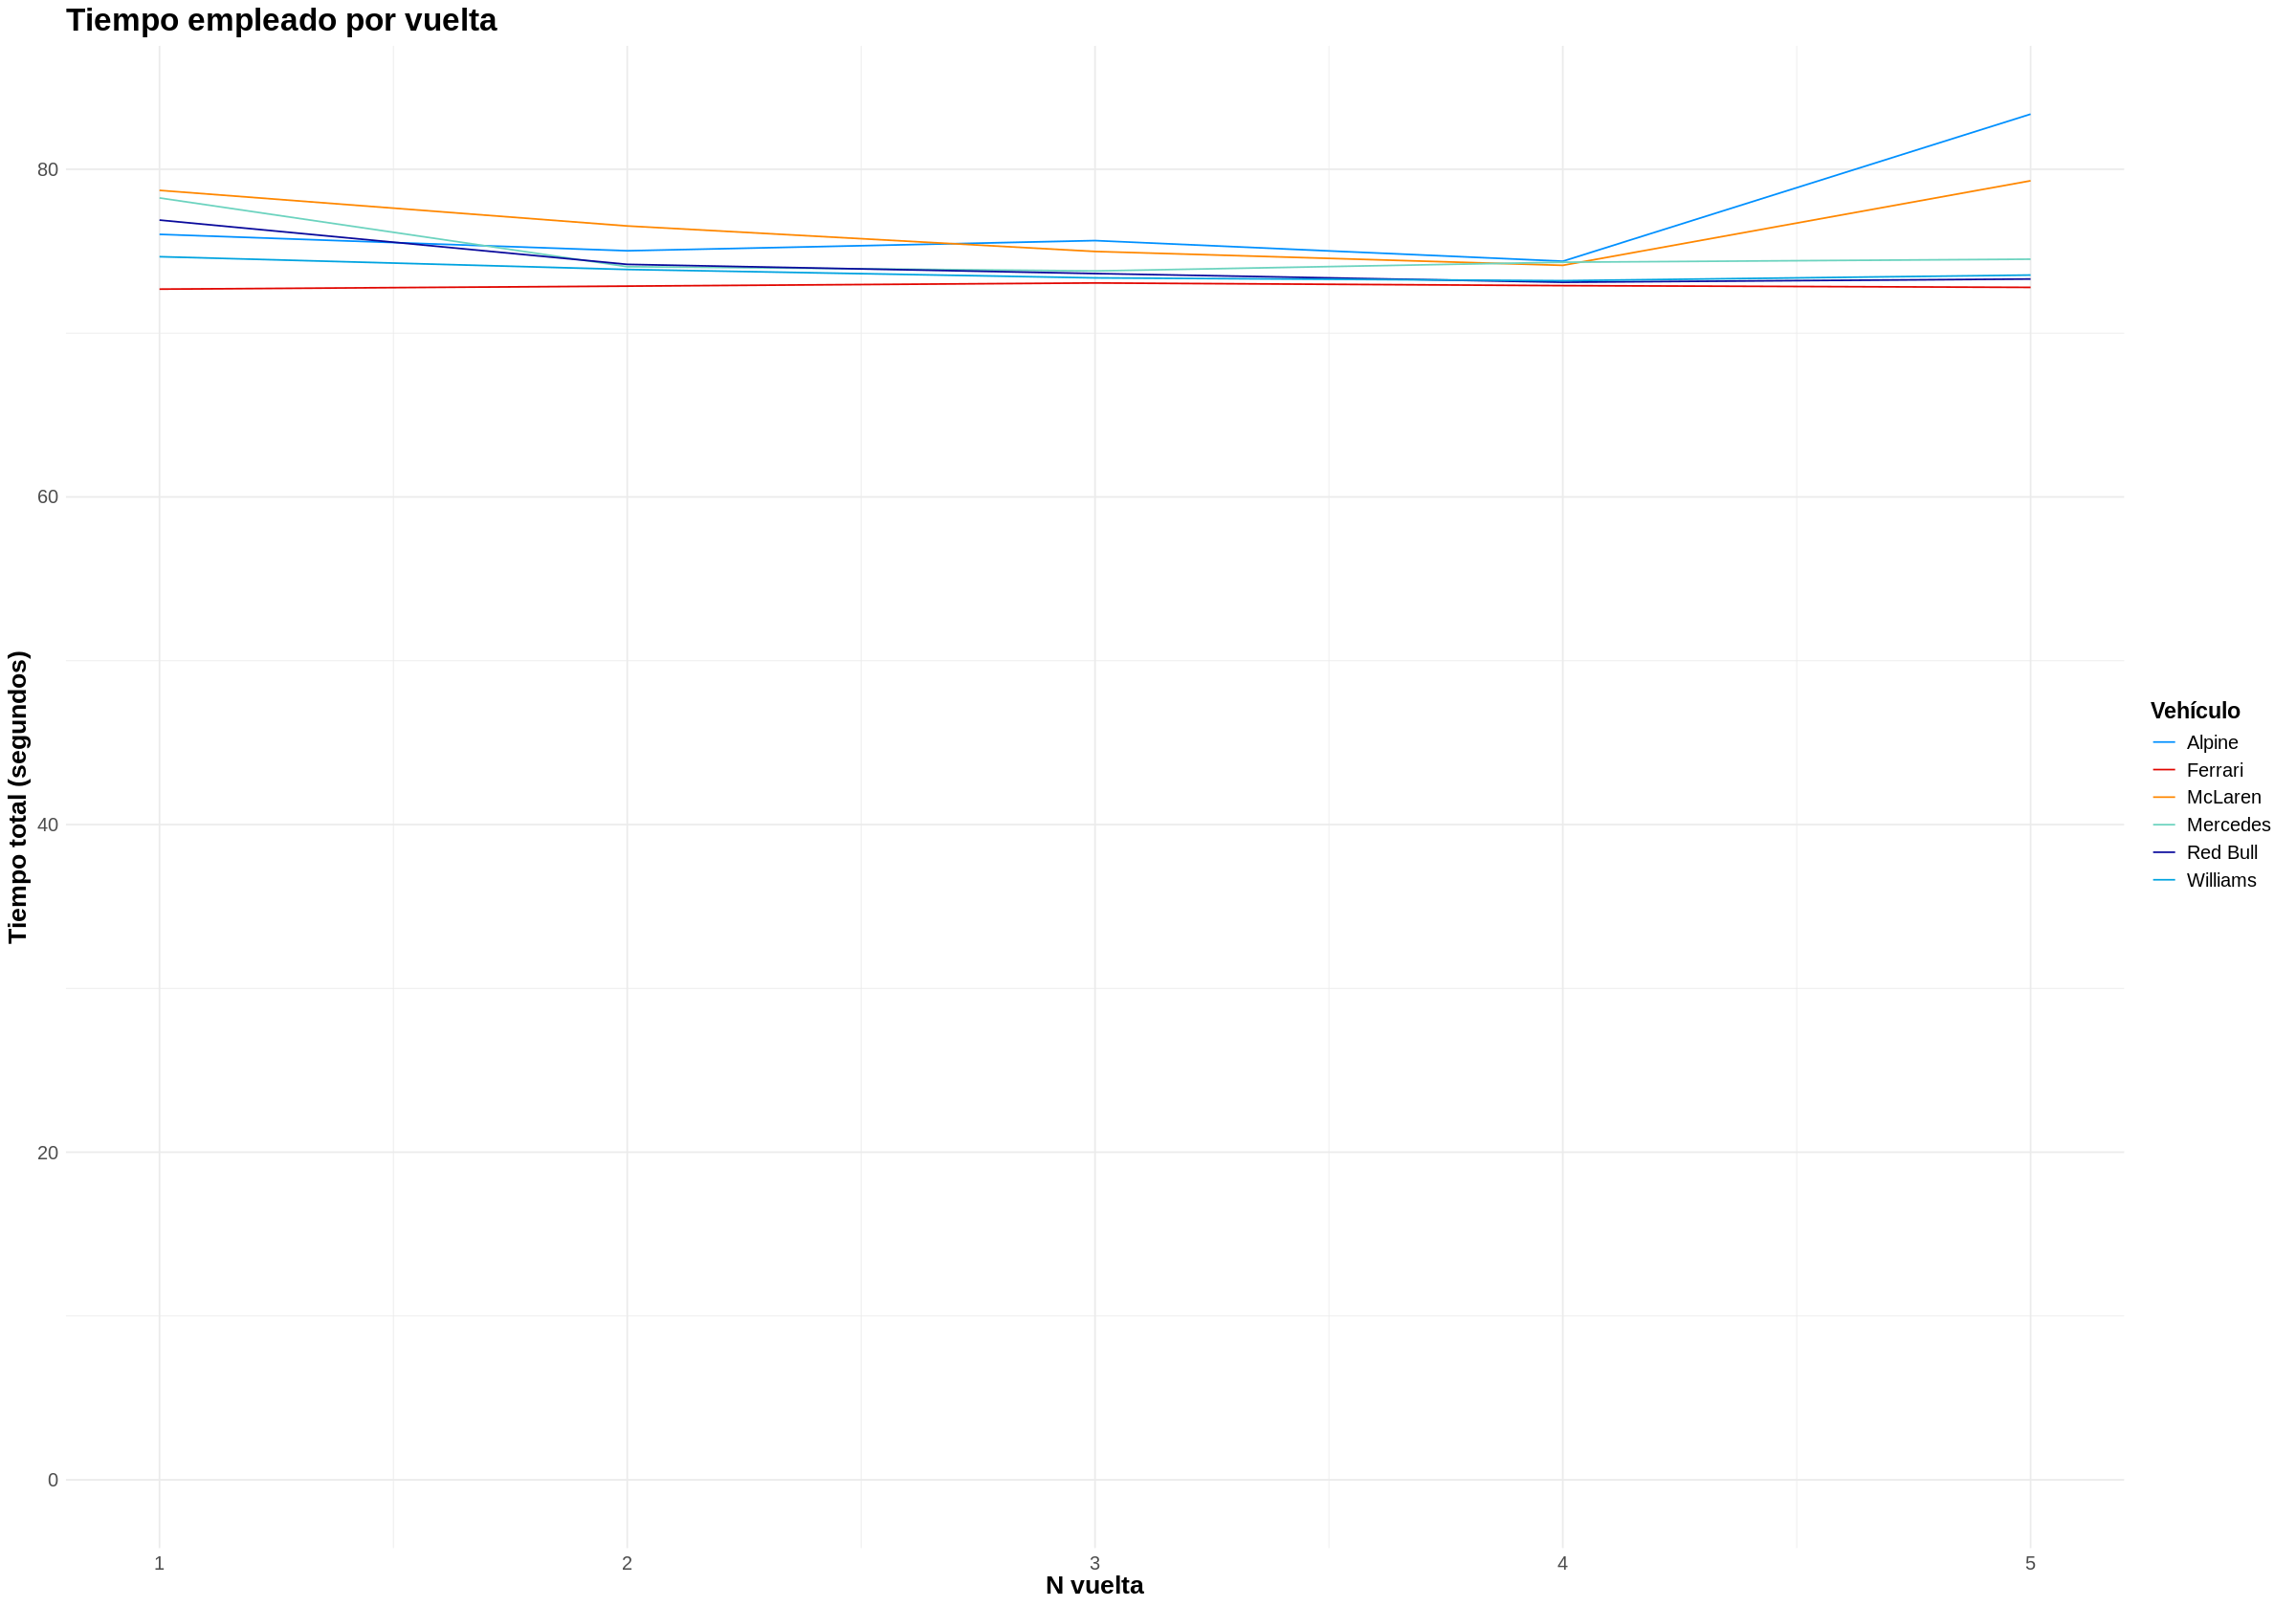

In [89]:
colores_f1 <- c(
  "FER" = "#E10600",  # Ferrari Red
  "RED" = "#0A0A9C",  # Red Bull Navy Blue
  "MCL" = "#FF8700",  # McLaren Papaya Orange
  "MER" = "#6CD3BF",  # Mercedes Teal
  "ALP" = "#0090FF",  # Alpine Blue
  "WIL" = "#00A3E0"   # Williams Light Blue
)

# Create a mapping for full team names
full_team_names <- c(
  "FER" = "Ferrari",
  "RED" = "Red Bull",
  "MCL" = "McLaren",
  "MER" = "Mercedes",
  "ALP" = "Alpine",
  "WIL" = "Williams"
)

# Add full team names to lap_times_summary
lap_times_summary_full <- lap_times_summary %>%
  mutate(full_carId = recode(carId, !!!full_team_names))

# Create a color map where names are full team names for the 'color' aesthetic
full_color_map <- setNames(colores_f1, full_team_names[names(colores_f1)])

ggplot(lap_times_summary_full, aes(x = lap_number, y = total_lap_time, color = full_carId)) +
  geom_line() +
  scale_color_manual(values = full_color_map, labels = full_team_names) + # Apply custom colors with full names for legend
  labs(
    title = "Tiempo empleado por vuelta",
    x = "N vuelta",
    y = "Tiempo total (segundos)",
    color = "Vehículo" # Update legend title
  ) +
  ylim(0, NA) + # Restricted y-axis between 70 and 100
  theme_minimal() +
  theme(
    plot.title = element_text(size = 20, face = "bold"), # Enlarge plot title
    axis.title.x = element_text(size = 16, face = "bold"), # Enlarge x-axis title
    axis.title.y = element_text(size = 16, face = "bold"), # Enlarge y-axis title
    axis.text.x = element_text(size = 12), # Enlarge x-axis text (lap numbers)
    axis.text.y = element_text(size = 12), # Enlarge y-axis text (time values)
    legend.title = element_text(size = 14, face = "bold"), # Enlarge legend title (carId)
    legend.text = element_text(size = 12) # Enlarge legend text (team names)
  )

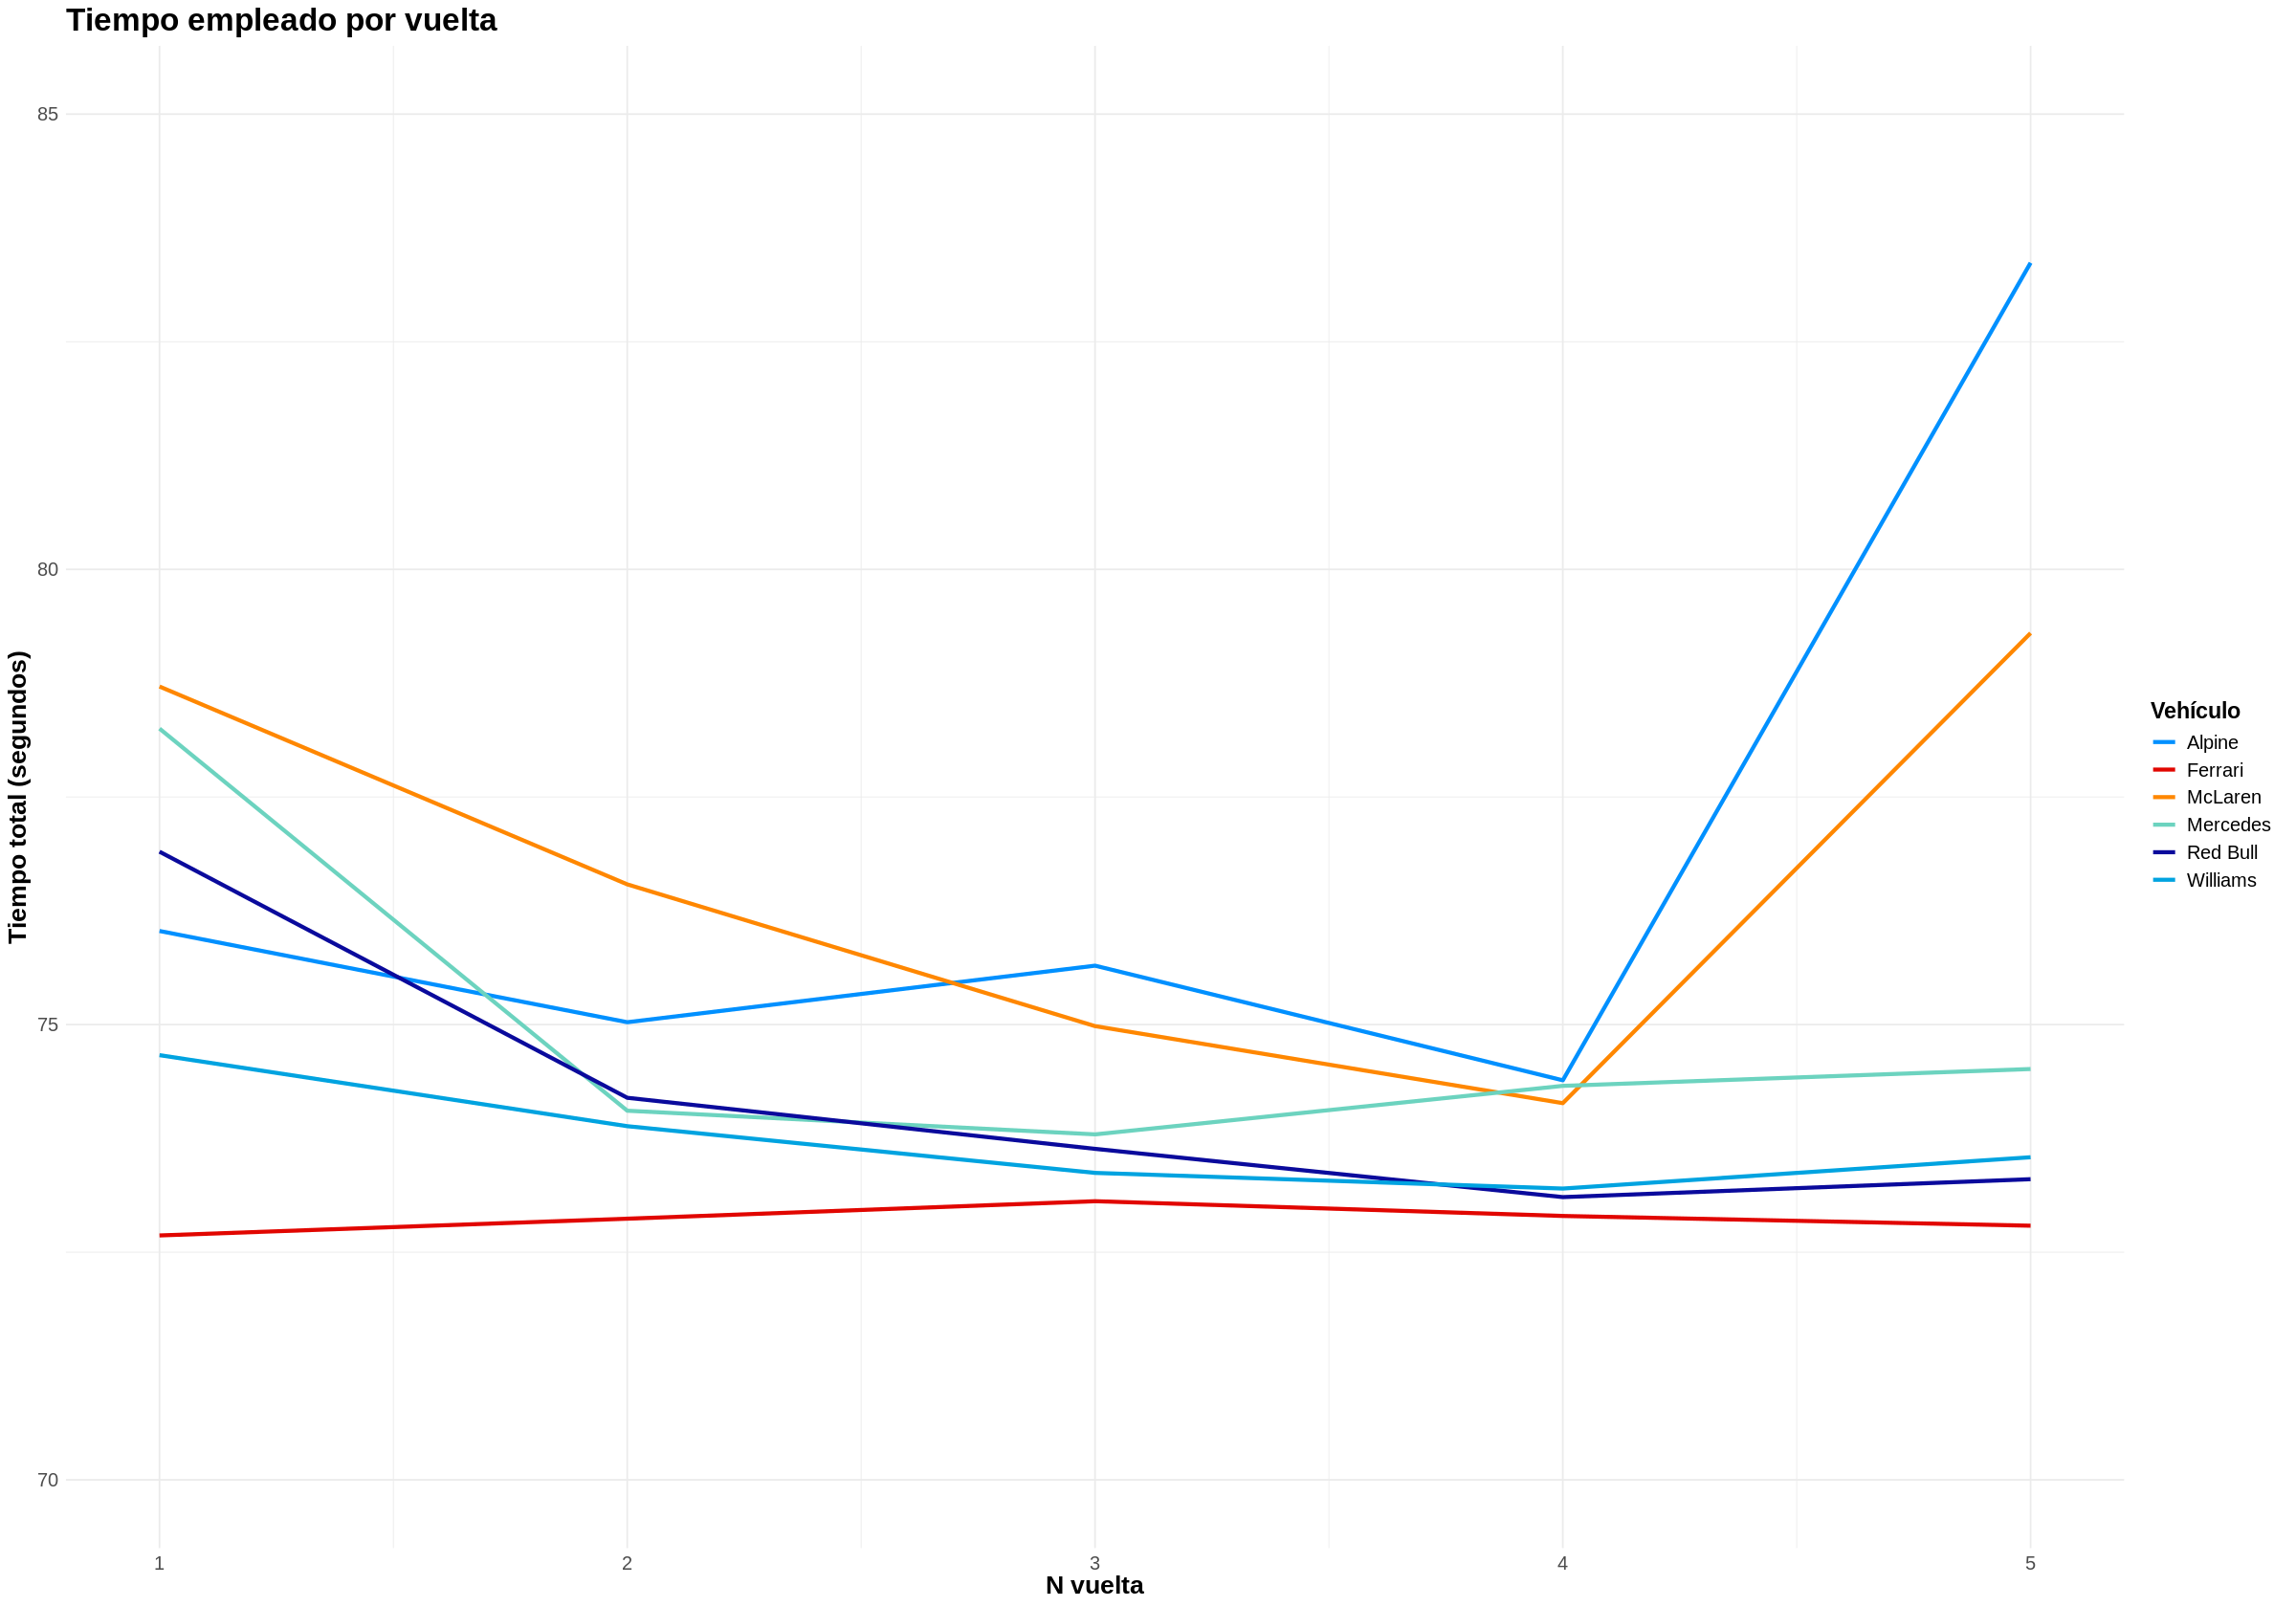

In [93]:
colores_f1 <- c(
  "FER" = "#E10600",  # Ferrari Red
  "RED" = "#0A0A9C",  # Red Bull Navy Blue
  "MCL" = "#FF8700",  # McLaren Papaya Orange
  "MER" = "#6CD3BF",  # Mercedes Teal
  "ALP" = "#0090FF",  # Alpine Blue
  "WIL" = "#00A3E0"   # Williams Light Blue
)

# Create a mapping for full team names
full_team_names <- c(
  "FER" = "Ferrari",
  "RED" = "Red Bull",
  "MCL" = "McLaren",
  "MER" = "Mercedes",
  "ALP" = "Alpine",
  "WIL" = "Williams"
)

# Add full team names to lap_times_summary
lap_times_summary_full <- lap_times_summary %>%
  mutate(full_carId = recode(carId, !!!full_team_names))

# Create a color map where names are full team names for the 'color' aesthetic
full_color_map <- setNames(colores_f1, full_team_names[names(colores_f1)])

ggplot(lap_times_summary_full, aes(x = lap_number, y = total_lap_time, color = full_carId)) +
  geom_line(linewidth = 1.2) + # Changed size to linewidth for updated ggplot2
  scale_color_manual(values = full_color_map, labels = full_team_names) + # Apply custom colors with full names for legend
  labs(
    title = "Tiempo empleado por vuelta",
    x = "N vuelta",
    y = "Tiempo total (segundos)",
    color = "Vehículo" # Update legend title
  ) +
  ylim(70, 85) + # Restricted y-axis between 70 and 100
  theme_minimal() +
  theme(
    plot.title = element_text(size = 20, face = "bold"), # Enlarge plot title
    axis.title.x = element_text(size = 16, face = "bold"), # Enlarge x-axis title
    axis.title.y = element_text(size = 16, face = "bold"), # Enlarge y-axis title
    axis.text.x = element_text(size = 12), # Enlarge x-axis text (lap numbers)
    axis.text.y = element_text(size = 12), # Enlarge y-axis text (time values)
    legend.title = element_text(size = 14, face = "bold"), # Enlarge legend title (carId)
    legend.text = element_text(size = 12) # Enlarge legend text (team names)
  )

In [73]:
print(lap_times_summary)

# A tibble: 30 × 3
   carId lap_number total_lap_time
   <chr>      <dbl>          <dbl>
 1 ALP            1           76.0
 2 ALP            2           75.0
 3 ALP            3           75.6
 4 ALP            4           74.4
 5 ALP            5           83.4
 6 FER            1           72.7
 7 FER            2           72.9
 8 FER            3           73.1
 9 FER            4           72.9
10 FER            5           72.8
# ℹ 20 more rows


El gráfico de nos permite observar el rendimiento de cada escudería a lo largo de cinco vueltas.


*   **Ferrari** y **Red Bull** demuestran ser las escuderías con los tiempos de vuelta más consistentes y rápidos en general, manteniéndose alrededor de los 72-73 segundos por vuelta.

*   **Mercedes** también exhibe un rendimiento sólido y consistente, con tiempos de vuelta ligeramente superiores a Ferrari y Red Bull, pero muy estables.

*   **McLaren** y **Williams** muestran tiempos de vuelta competitivos en las primeras vueltas, pero Williams presenta una leve tendencia a aumentar sus tiempos en las últimas vueltas válidas.

*   **Alpine** presenta una anomalía significativa en la vuelta 5, donde su tiempo total de vuelta se dispara a 83.4 segundos, mientras que el resto de sus vueltas están en el rango de 74-76 segundos.

*   La **consistencia** es una característica notable para la mayoría de las escuderías en sus vueltas válidas (1 a 4), lo que indica un rendimiento estable bajo condiciones de carrera normales.

#Actividad 3 (Grafico 2)

Represente gráficamente la información correspondiente a los tiempos de vuelta para cada vehículo mediante diagramas de caja (boxplots) y diagrama de violín.

# Boxplots y Diagramas de Violín de Tiempos por Vuelta

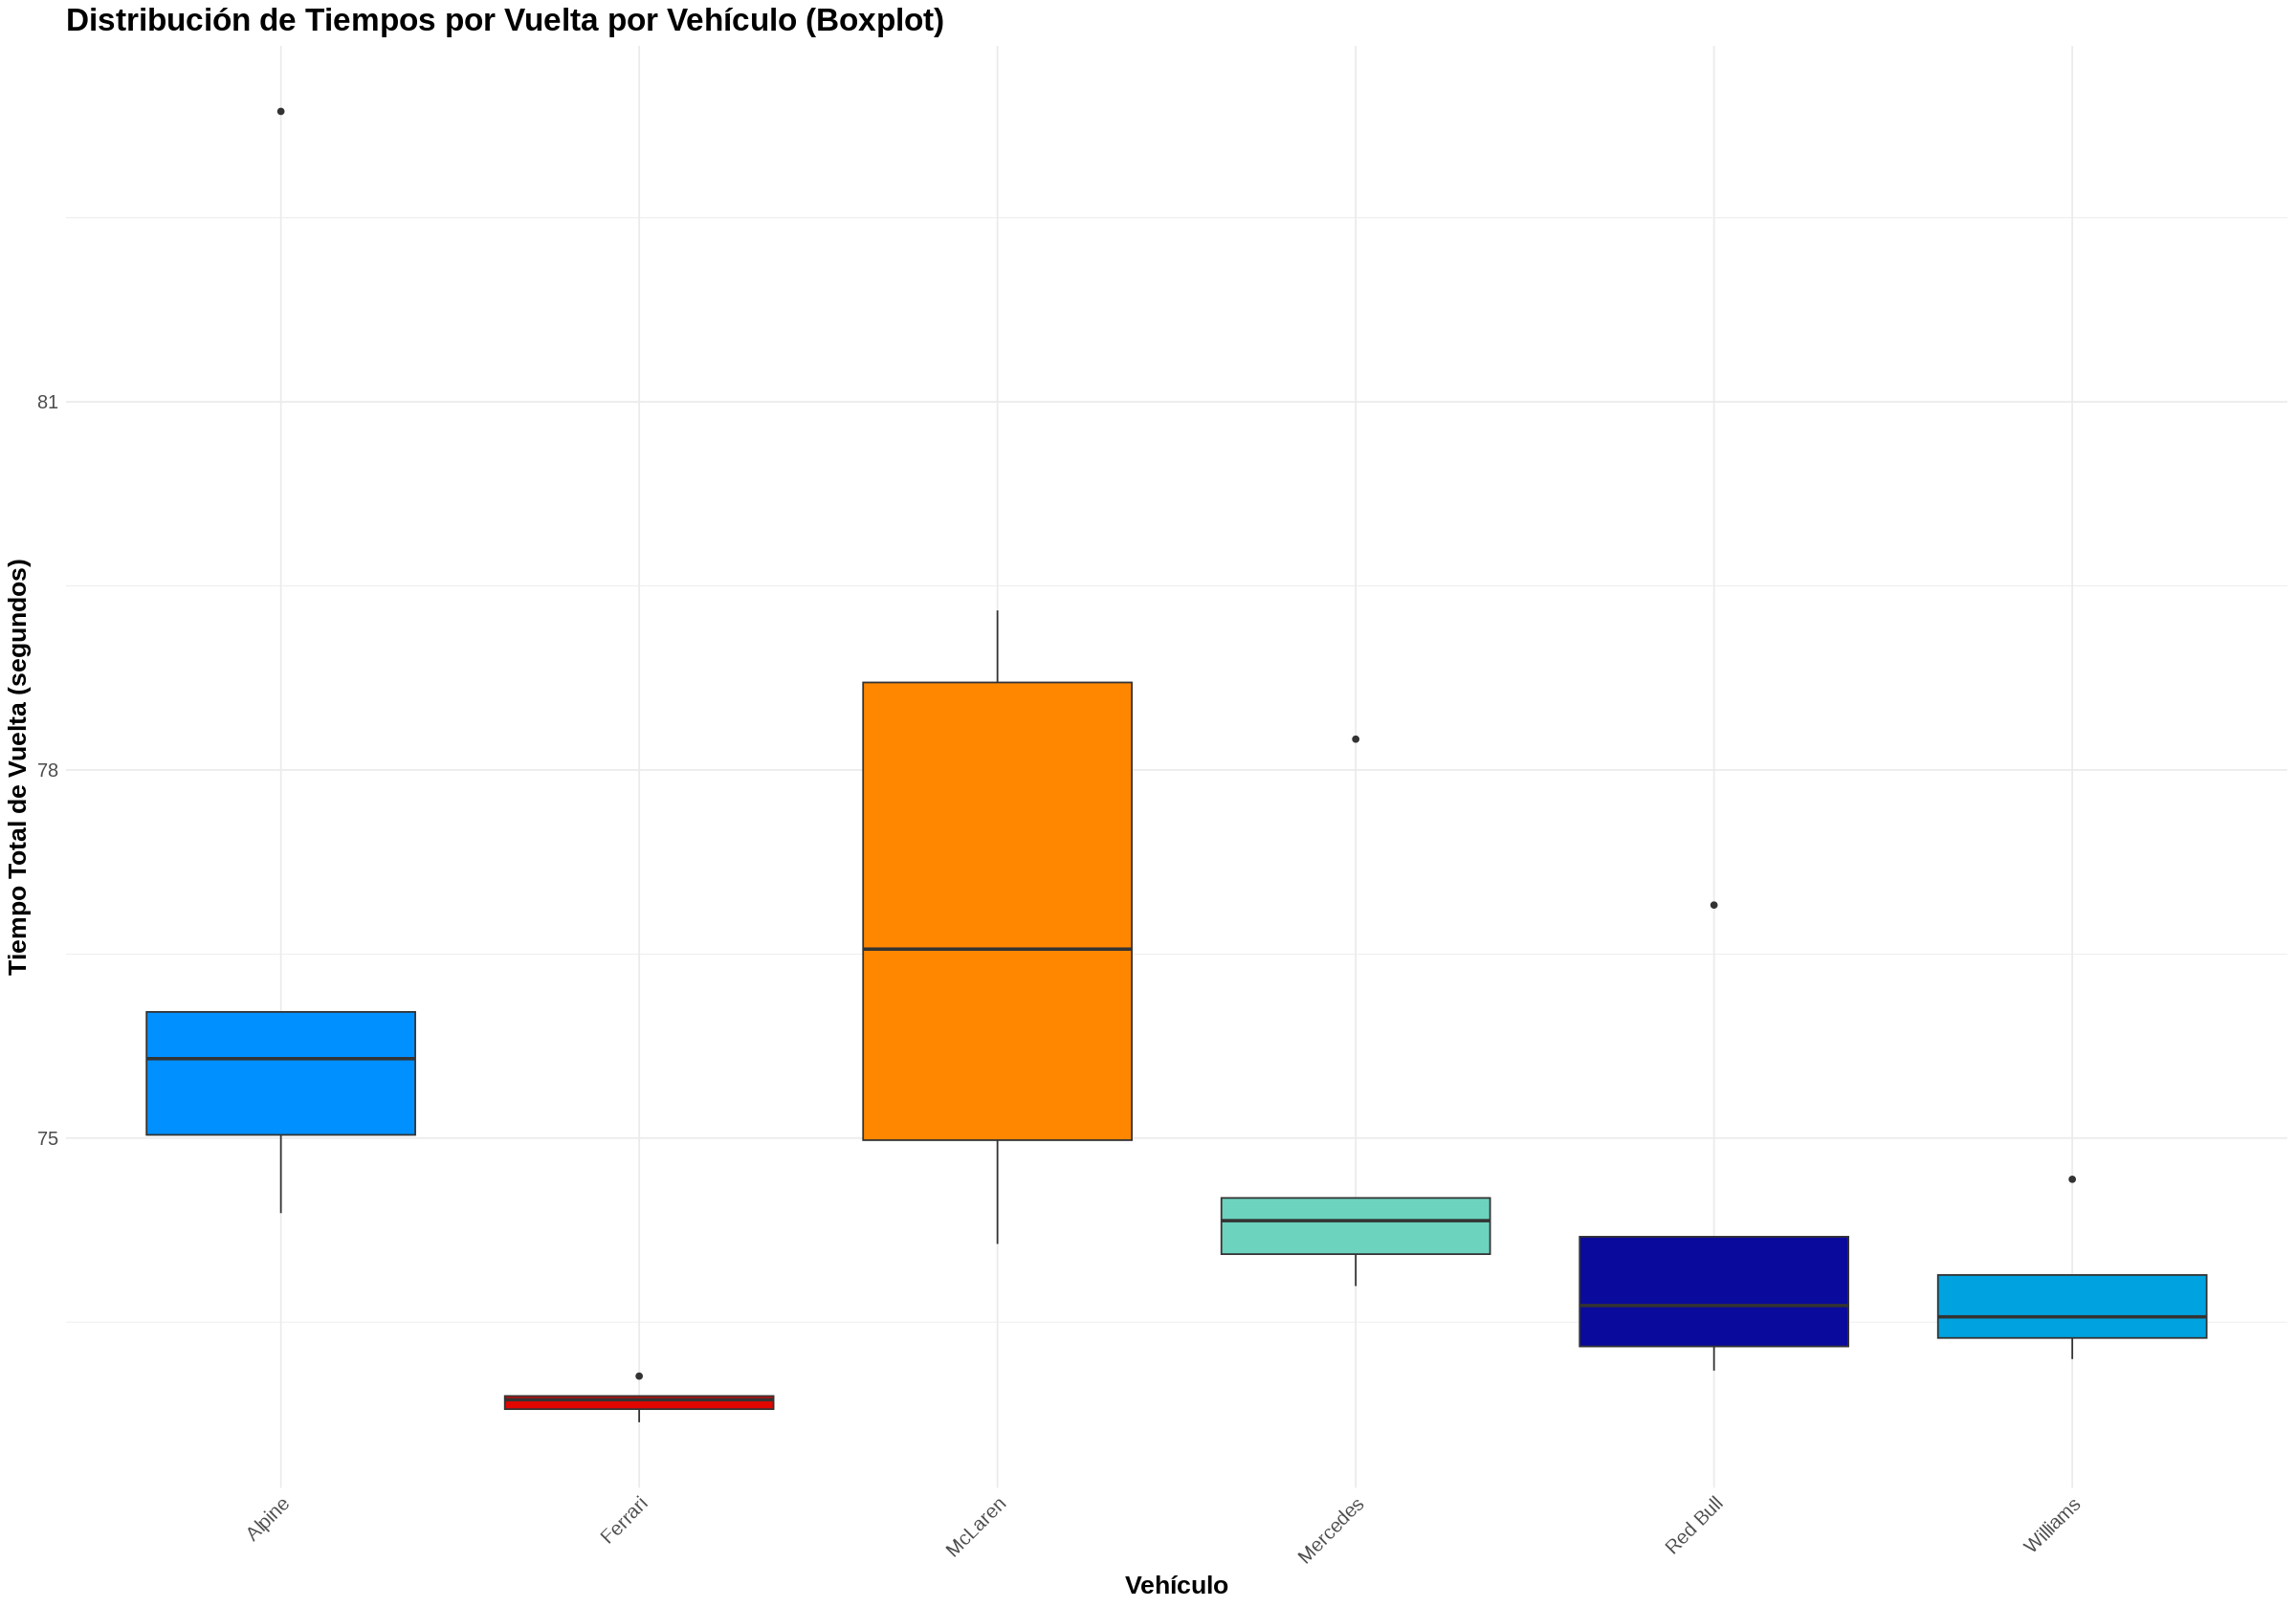

In [84]:
colores_f1 <- c(
  "FER" = "#E10600",  # Ferrari Red
  "RED" = "#0A0A9C",  # Red Bull Navy Blue
  "MCL" = "#FF8700",  # McLaren Papaya Orange
  "MER" = "#6CD3BF",  # Mercedes Teal
  "ALP" = "#0090FF",  # Alpine Blue
  "WIL" = "#00A3E0"   # Williams Light Blue
)

# Create a mapping for full team names
full_team_names <- c(
  "FER" = "Ferrari",
  "RED" = "Red Bull",
  "MCL" = "McLaren",
  "MER" = "Mercedes",
  "ALP" = "Alpine",
  "WIL" = "Williams"
)

# Add full team names to lap_times_summary
lap_times_summary_full <- lap_times_summary %>%
  mutate(full_carId = recode(carId, !!!full_team_names))

ggplot(lap_times_summary_full, aes(x = full_carId, y = total_lap_time, fill = carId)) +
  geom_boxplot() +
  scale_fill_manual(values = colores_f1, labels = full_team_names) + # Apply custom colors with full names for legend
  labs(
    title = "Distribución de Tiempos por Vuelta por Vehículo (Boxplot)",
    x = "Vehículo",
    y = "Tiempo Total de Vuelta (segundos)"
  ) +
  theme_minimal() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 20, face = "bold"), # Enlarge plot title
    axis.title.x = element_text(size = 16, face = "bold"), # Enlarge x-axis title
    axis.title.y = element_text(size = 16, face = "bold"), # Enlarge y-axis title
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1), # Enlarge and rotate x-axis text
    axis.text.y = element_text(size = 12) # Enlarge y-axis text
  )

El diagrama de caja (boxplot) muestra la mediana, los cuartiles y los valores atípicos de los tiempos de vuelta para cada coche. Nos da una idea rápida de la dispersión de los datos.

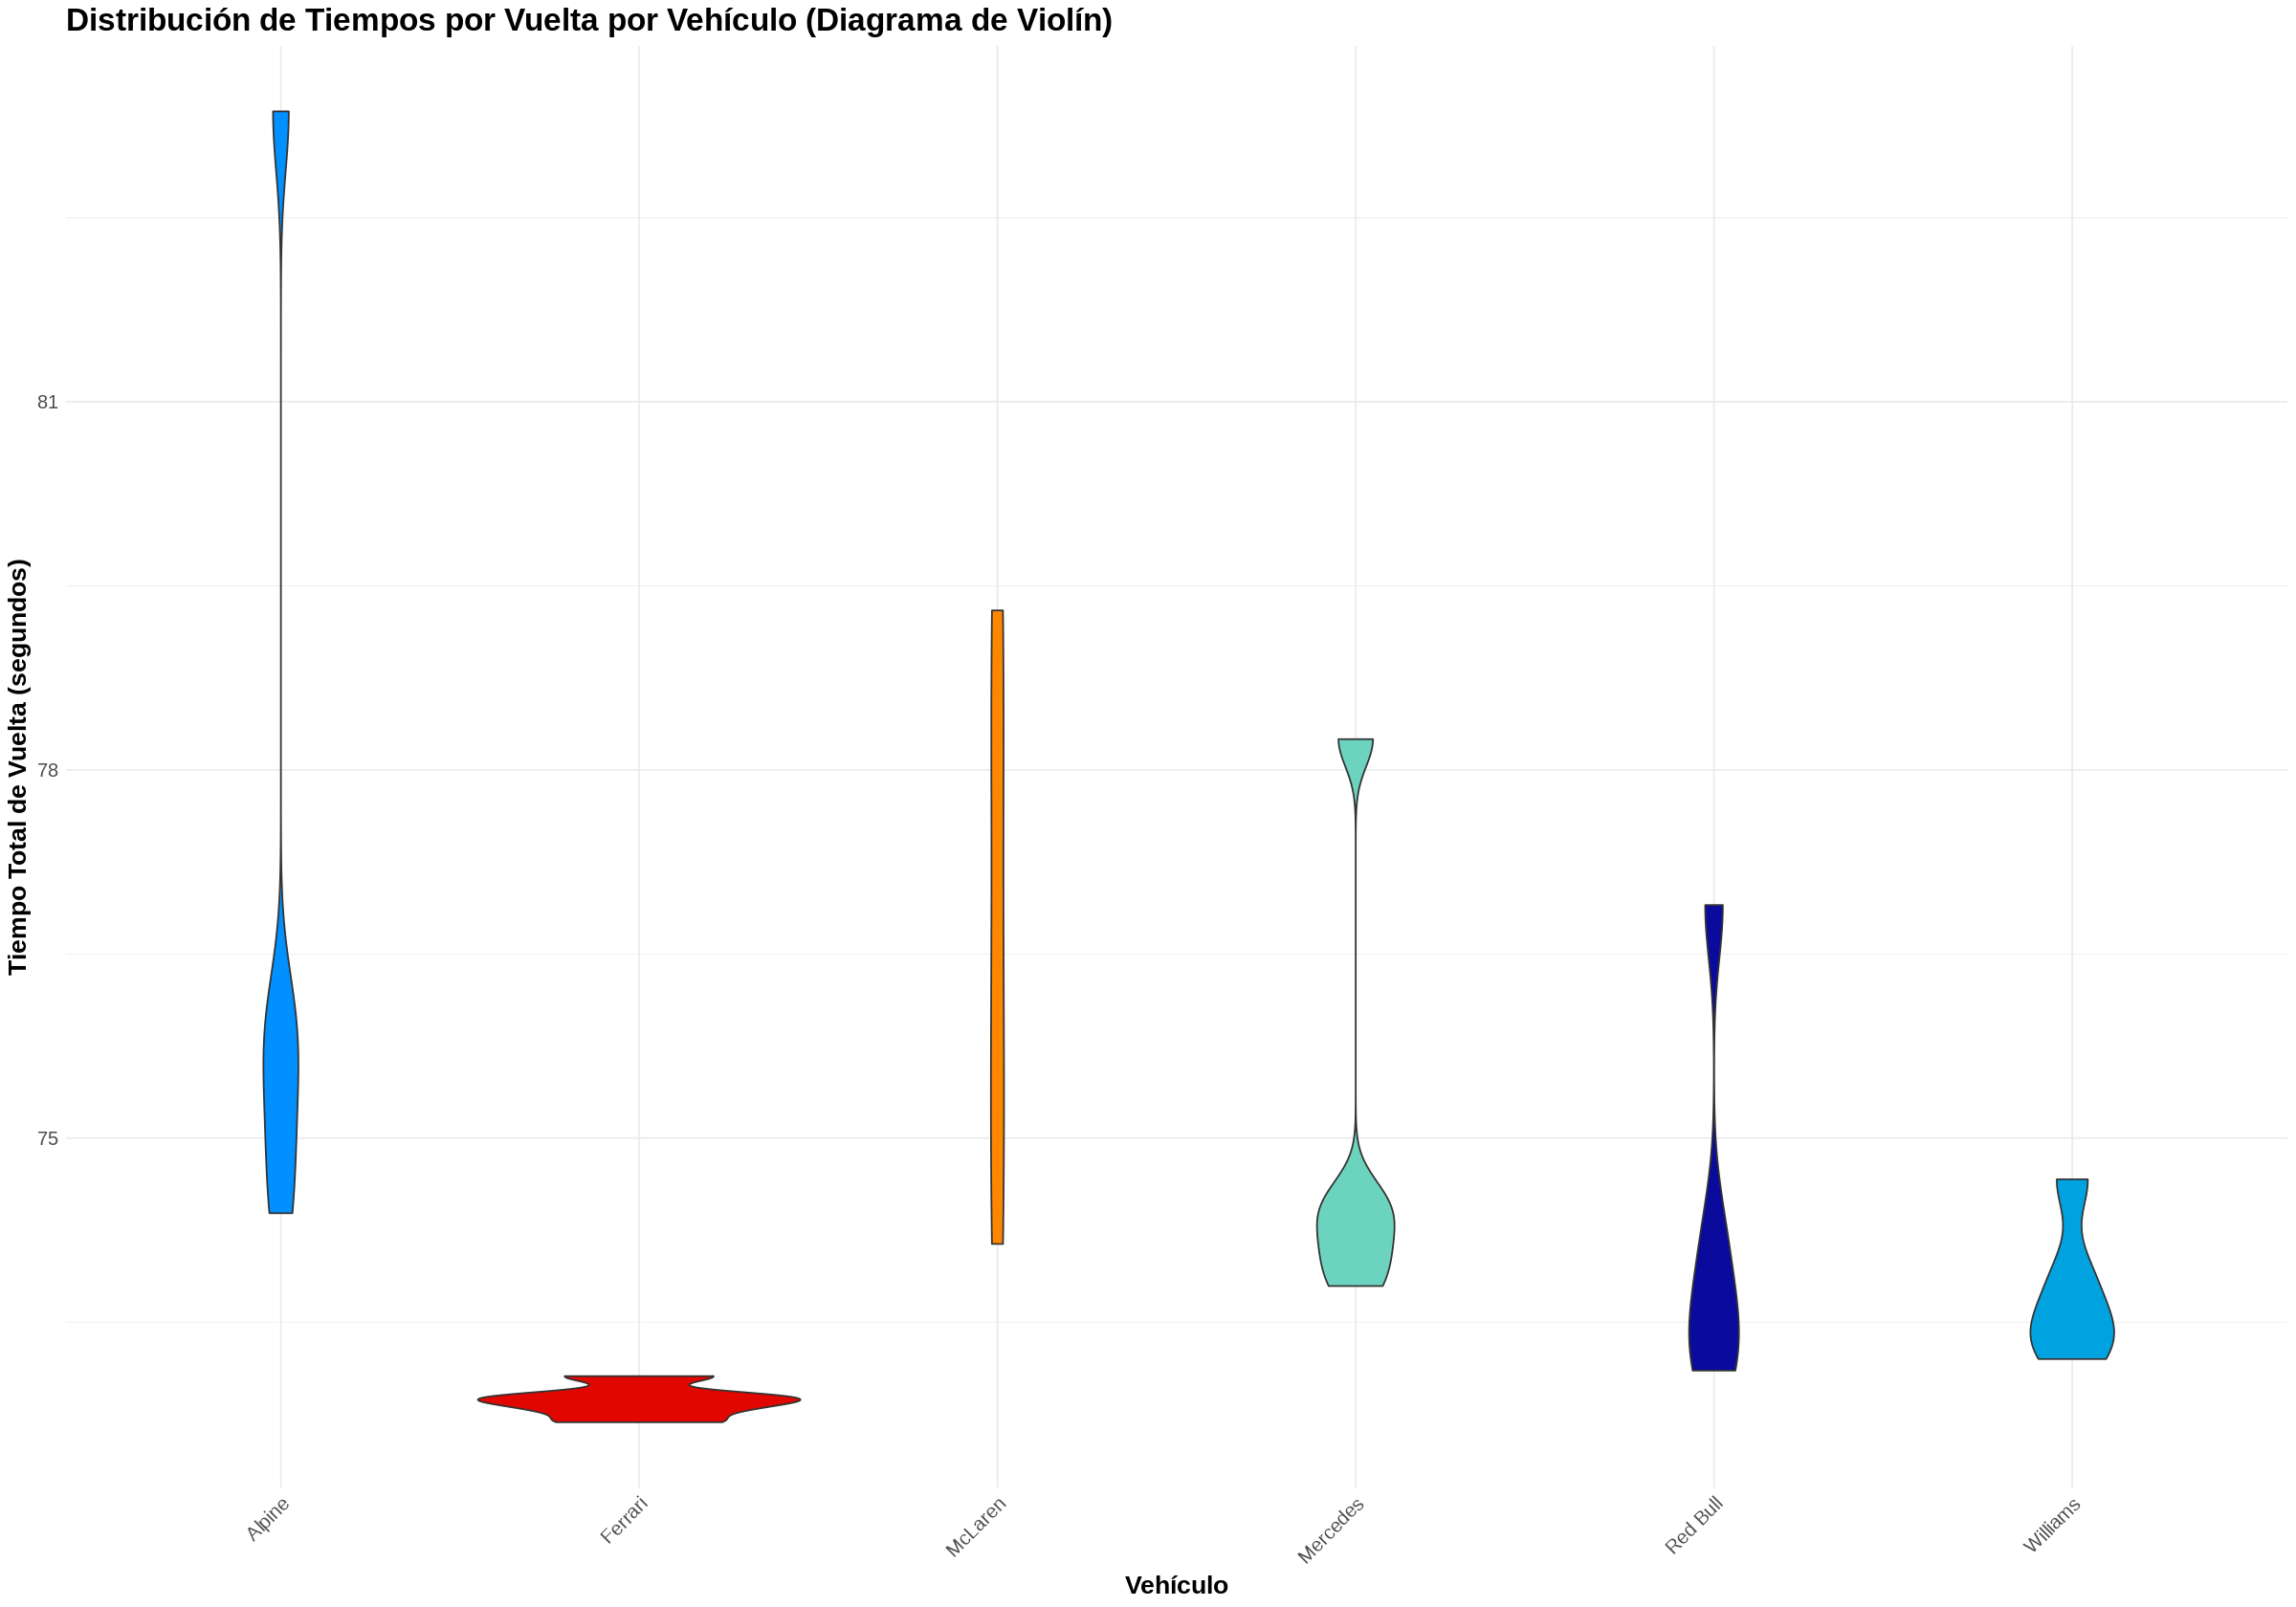

In [94]:
colores_f1 <- c(
  "FER" = "#E10600",  # Ferrari Red
  "RED" = "#0A0A9C",  # Red Bull Navy Blue
  "MCL" = "#FF8700",  # McLaren Papaya Orange
  "MER" = "#6CD3BF",  # Mercedes Teal
  "ALP" = "#0090FF",  # Alpine Blue
  "WIL" = "#00A3E0"   # Williams Light Blue
)

# Create a mapping for full team names
full_team_names <- c(
  "FER" = "Ferrari",
  "RED" = "Red Bull",
  "MCL" = "McLaren",
  "MER" = "Mercedes",
  "ALP" = "Alpine",
  "WIL" = "Williams"
)

# Add full team names to lap_times_summary
lap_times_summary_full <- lap_times_summary %>%
  mutate(full_carId = recode(carId, !!!full_team_names))

ggplot(lap_times_summary_full, aes(x = full_carId, y = total_lap_time, fill = carId)) +
  geom_violin() +
  scale_fill_manual(values = colores_f1, labels = full_team_names) + # Apply custom colors with full names for legend
  labs(
    title = "Distribución de Tiempos por Vuelta por Vehículo (Diagrama de Violín)",
    x = "Vehículo",
    y = "Tiempo Total de Vuelta (segundos)"
  ) +
  theme_minimal() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 20, face = "bold"), # Enlarge plot title
    axis.title.x = element_text(size = 16, face = "bold"), # Enlarge x-axis title
    axis.title.y = element_text(size = 16, face = "bold"), # Enlarge y-axis title
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1), # Enlarge and rotate x-axis text
    axis.text.y = element_text(size = 12) # Enlarge y-axis text
  )

El diagrama de violín es similar al boxplot, pero añade una representación de la densidad de probabilidad de los datos, lo que permite observar la forma de la distribución y la moda (picos de densidad) de los tiempos de vuelta para cada vehículo.
Por otro lado, yendo al análisis de los datos en sí, podemos concluír que;
Ferrari y Williams son los que menos distribución tienen, todos sus tiempos se mantuvieron dentro de un rango específico, mientras que todo el resto muestra valores más dispersos.
En el caso de Alpine, como fue anteriormente mencionado, da un salto de sus tiempos anteriores(Más consistentes) a 83.4.
En el caso de Mercedes y Redbull, también vemos que sus datos están dispersos, aunque no de forma tan extrema como Alpine.
Por último, McClaren parece tener una distribución simétrica - la diferencia entre un tiempo y otro es muy similar, haciendo que tanto en el boxplot como en el violín se vean uniformes sus representaciones gráficas.

#Actividad 4 (Cuadro 1)

Elabore un cuadro donde se muestre para cada uno de los vehículos, el mejor tiempo de vuelta (lap_time), el mejor tiempo registrado en cada uno de los sectores y la velocidad máxima registrada en cada uno de los vehículos. El gráfico debe estar ordenado en base al mejor tiempo de vuelta del más rápido al más lento.

# Mejores tiempos, mejores corredores...


In [95]:
best_lap_overall <- lap_times_summary %>%
  group_by(carId) %>%
  summarise(best_lap_time = min(total_lap_time, na.rm = TRUE))

sector_times_raw <- telemetria %>%
  filter(binIndex %in% c(1430, 2861, 4293)) %>%
  select(carId, lap_number, binIndex, lap_time) %>%
  arrange(carId, lap_number, binIndex)

sector_times_pivot <- sector_times_raw %>%
  pivot_wider(
    names_from = binIndex,
    values_from = lap_time,
    names_prefix = "bin_"
  )

sector_times_calculated <- sector_times_pivot %>%
  mutate(
    sector1_time = bin_1430,
    sector2_time = bin_2861 - bin_1430,
    sector3_time = bin_4293 - bin_2861
  ) %>%
  select(carId, lap_number, sector1_time, sector2_time, sector3_time)

best_sector_times <- sector_times_calculated %>%
  group_by(carId) %>%
  summarise(
    best_sector1 = min(sector1_time, na.rm = TRUE),
    best_sector2 = min(sector2_time, na.rm = TRUE),
    best_sector3 = min(sector3_time, na.rm = TRUE)
  )

max_velocity_overall <- telemetria %>%
  group_by(carId) %>%
  summarise(max_velocity = max(velocidad, na.rm = TRUE))

summary_table <- best_lap_overall %>%
  left_join(best_sector_times, by = "carId") %>%
  left_join(max_velocity_overall, by = "carId") %>%
  arrange(best_lap_time)

print(summary_table)

# A tibble: 6 × 6
  carId best_lap_time best_sector1 best_sector2 best_sector3 max_velocity
  <chr>         <dbl>        <dbl>        <dbl>        <dbl>        <dbl>
1 FER            72.7         21.7         28.8         22           316.
2 RED            73.1         21.7         29.3         22.0         316.
3 WIL            73.2         21.8         29.0         22.0         316.
4 MER            73.8         21.9         29.7         22.1         316.
5 MCL            74.1         22.1         29.7         22.2         316.
6 ALP            74.4         22.2         29.8         22.1         315.


# Análisis del Cuadro

Este cuadro nos permite comparar el rendimiento de cada escudería para poder entender que:

- Excepto Alpine, todos los demás corredores tuvieron la misma velocidad; 316.
- Ferrari es el que mejor tiempo tuvo en general respecto de todos los demás.
- En el sector 3 fue donde menos variarion los tiempos, que puede deberse a la forma en la que el circuito de Interlagos está diseñado (22.0 - 22.2).
- Por lo recién explicado, el circuito dos es el que más curvas y complicaciones tiene, por lo que es lógico que en general todos los corredores hayan tardado más que en otros sectores y haya variado de forma más notoria el tiempo (28.8 - 29.8).
- A pesar de lo mostrado en otros sectores, en el sector 1 fue donde hubo más variabilidad (72.7 - 74.4).

#Activiad 5 (Grafico 3)

Elabore un gráfico que represente las variaciones en las posiciones de cada una de los pilotos a lo largo de la carrera. En el eje de las abscisas (X) se deben mostrar las vueltas, mientras que en el eje de las ordenadas (Y) se indicará la posición ocupada por cada escudería.

#Actividad 6 (Grafico 4)
Elabore un gráfico que muestre la velocidad máxima para cada uno de los vehículos, ordenado desde el más rápido al más lento. En el eje de las abscisas (X), se representarán los vehículos, mientras que en el eje de las ordenadas (Y) se plasmará la velocidad máxima por cada vehículo.

#Actividad 7 (Grafico 5)
 Represente gráficamente la información correspondiente a las máximas velocidades por vuelta para cada vehículo mediante diagramas de caja (boxplots) y diagrama de violín. Gráfico similar al punto 2. Son dos gráficos por separado.

#Actividad 8 (Grafico 6)

Elabore un gráfico que muestren los mejores tiempos para cada uno de los vehículos en cada uno de los sectores, ordenando los tiempos de menor a mayor. En el eje de las abscisas (X), se representarán los vehículos, mientras que en el eje de las ordenadas (Y) se plasmará el tiempo empleado por cada.


 Generando Gráfico 7 (Sectores Separados)...


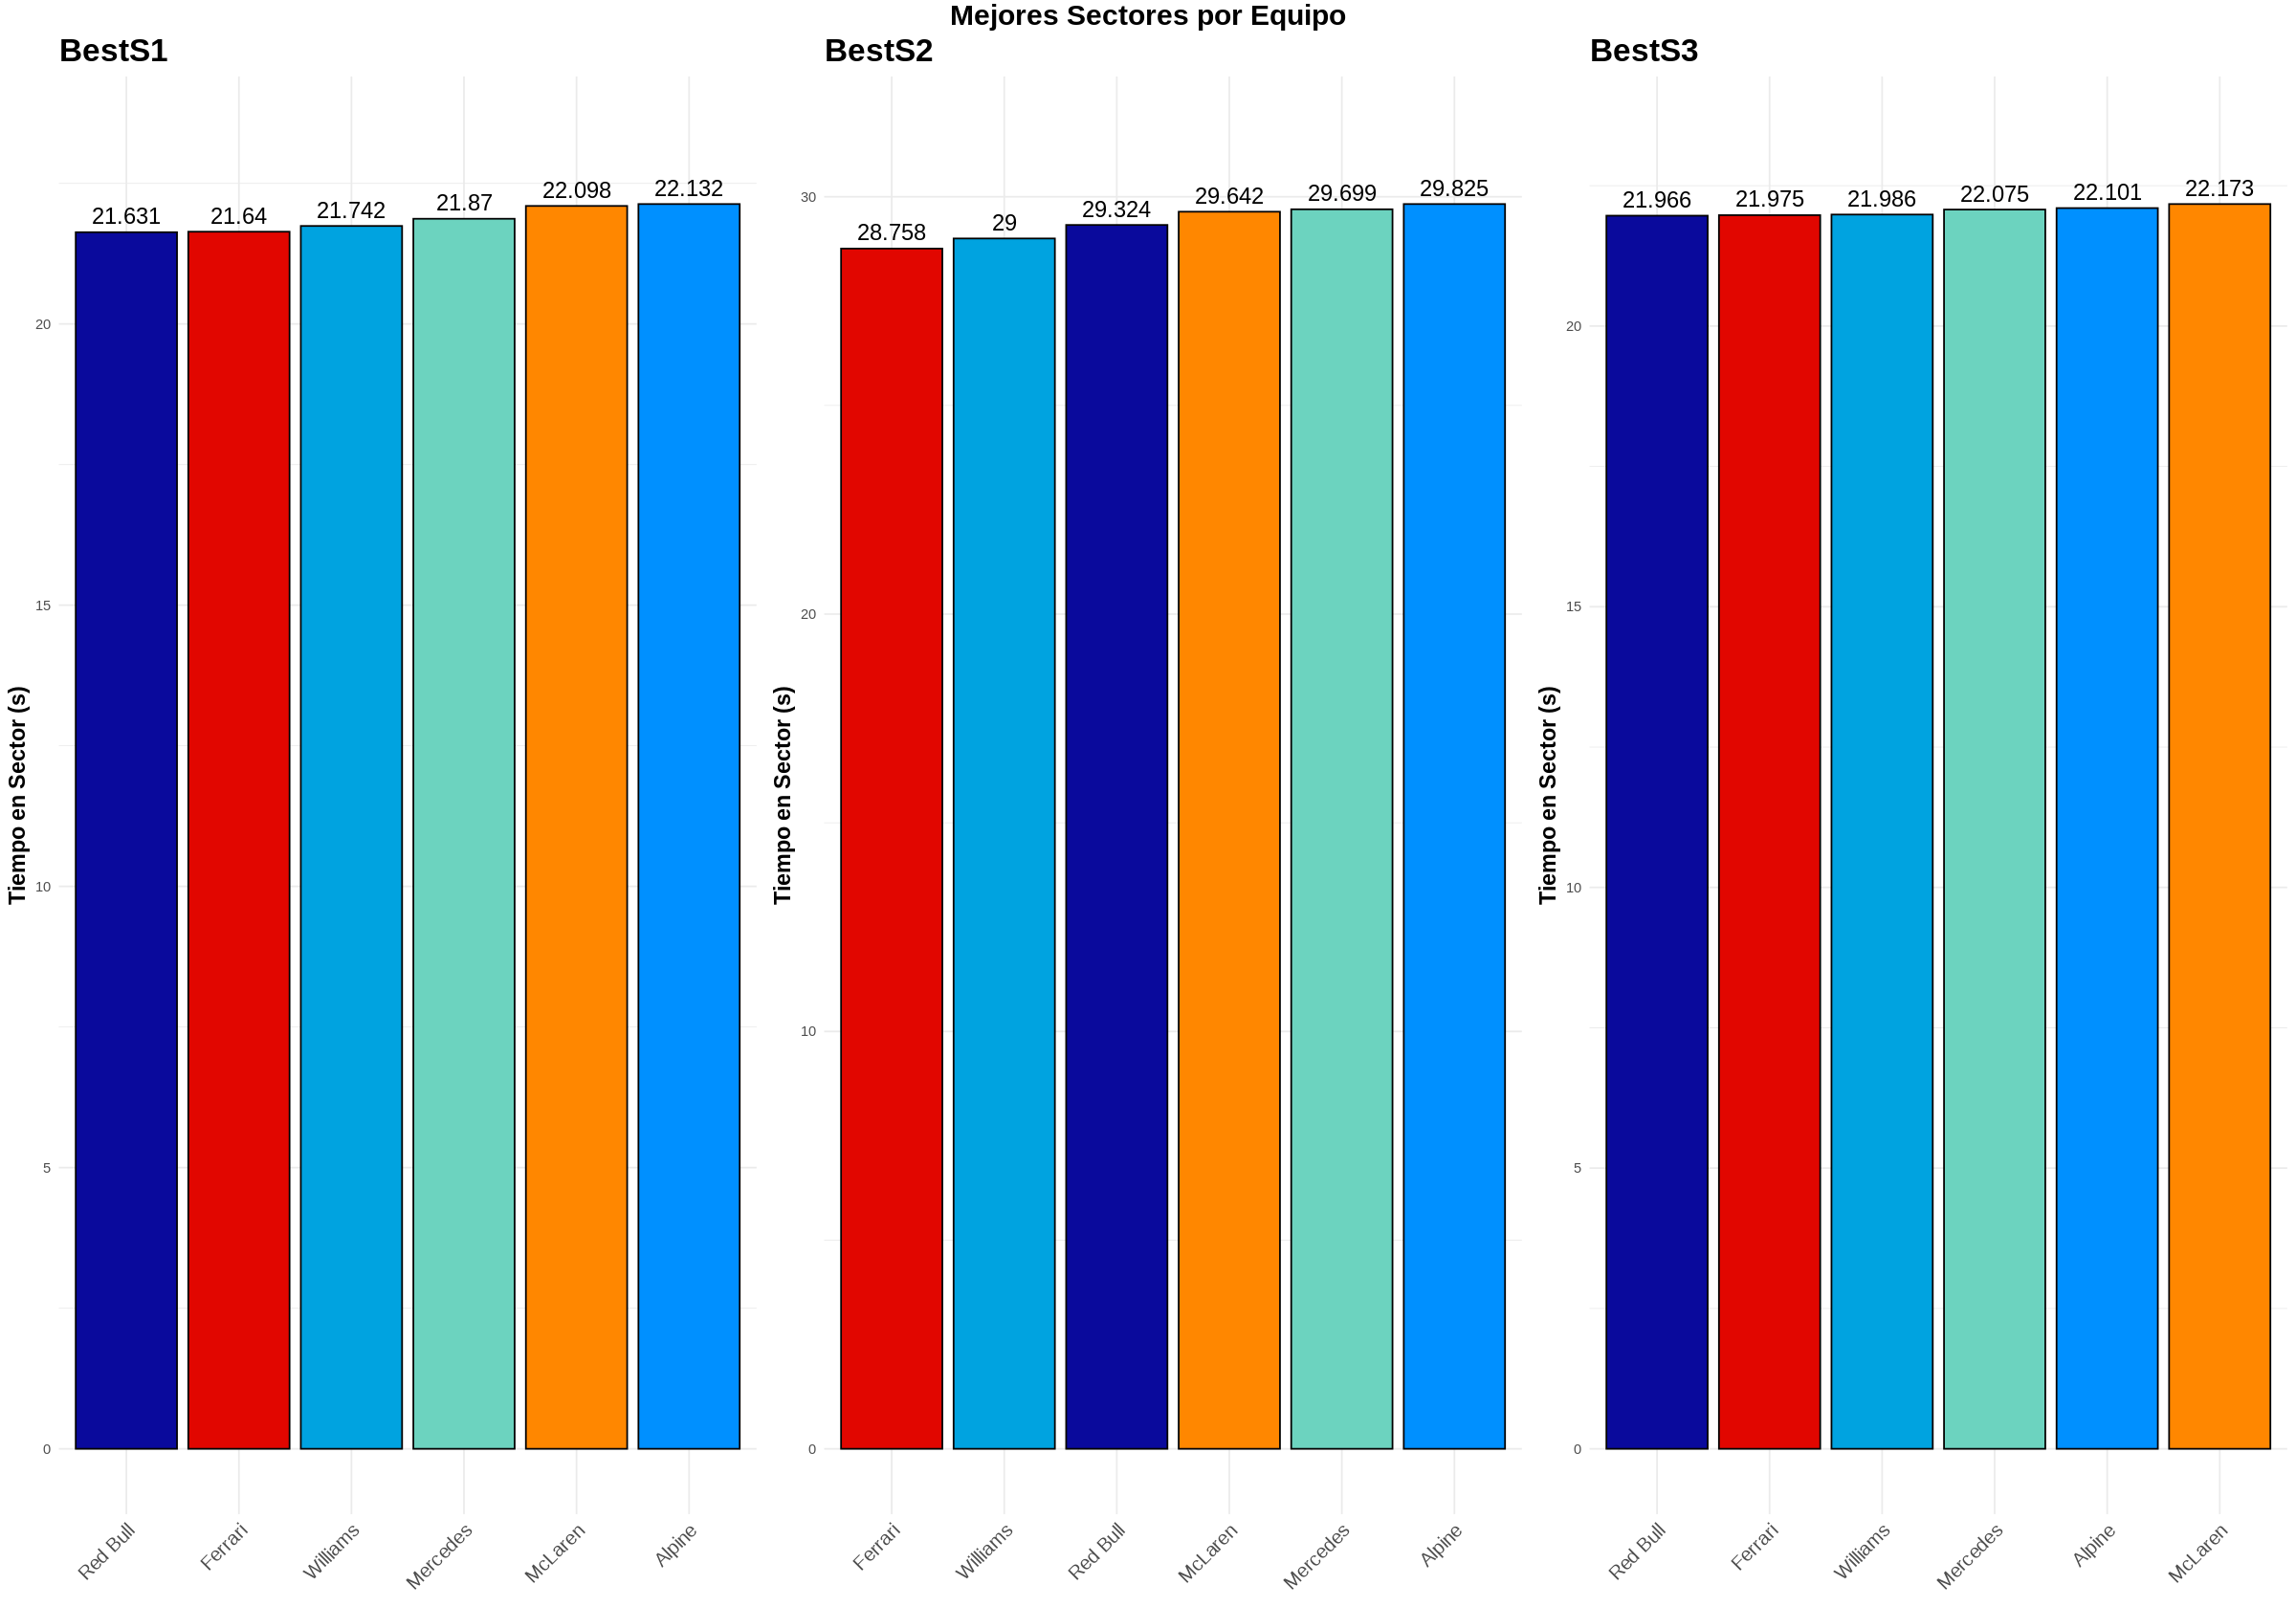

In [63]:
best_sector_times <- telemetria %>%
  group_by(carId, lap_number, sector) %>%
  summarise(
    sector_time = max(lap_time, na.rm = TRUE) - min(lap_time, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  group_by(carId, sector) %>%
  summarise(
    best_sector_time = min(sector_time, na.rm = TRUE),
    .groups = 'drop'
  )

# Define custom bright team colors (colores_f1)
colores_f1 <- c(
  "FER" = "#E10600",  # Ferrari Red
  "RED" = "#0A0A9C",  # Red Bull Navy Blue
  "MCL" = "#FF8700",  # McLaren Papaya Orange
  "MER" = "#6CD3BF",  # Mercedes Teal
  "ALP" = "#0090FF",  # Alpine Blue
  "WIL" = "#00A3E0"   # Williams Light Blue
)

# Create a mapping for full team names
full_team_names <- c(
  "FER" = "Ferrari",
  "RED" = "Red Bull",
  "MCL" = "McLaren",
  "MER" = "Mercedes",
  "ALP" = "Alpine",
  "WIL" = "Williams"
)

# Create tabla_mejores by pivoting wider
tabla_mejores <- best_sector_times %>%
  pivot_wider(names_from = sector, values_from = best_sector_time, names_prefix = "Best")

# Reshape to long format for plotting and add full team names
sectores_long <- tabla_mejores %>%
  select(carId, BestS1, BestS2, BestS3) %>%
  pivot_longer(cols = -carId, names_to = "Sector", values_to = "Tiempo") %>%
  mutate(full_carId = recode(carId, !!!full_team_names)) # Add full team names

# Function to plot each sector
plot_sector <- function(data, sec) {
  df_s <- data %>% filter(Sector == sec)
  ggplot(df_s, aes(x = reorder(full_carId, Tiempo), y = Tiempo, fill = carId)) +
    geom_col(color="black") +
    geom_text(aes(label=round(Tiempo,3)), vjust=-0.5, size=5) + # Increased size to 5
    scale_fill_manual(values = colores_f1) +
    coord_cartesian(ylim = c(0, max(df_s$Tiempo, na.rm = TRUE)*1.05)) +
    labs(title = sec, x = NULL, y = "Tiempo en Sector (s)") + # Changed y-axis label to be more descriptive
    theme_minimal() +
    theme(legend.position = "none",
          axis.text.x = element_text(angle = 45, hjust = 1, size = 12), # Increased x-axis text size to 12
          axis.title.y = element_text(size = 14, face = "bold"), # Increased y-axis title size and made bold
          plot.title = element_text(size = 20, face = "bold")) # Increased title size and made bold
}

cat("\n Generando Gráfico 7 (Sectores Separados)...\n")
p_s1 <- plot_sector(sectores_long, "BestS1")
p_s2 <- plot_sector(sectores_long, "BestS2")
p_s3 <- plot_sector(sectores_long, "BestS3")

# Arrange the plots with a larger main title
grid.arrange(p_s1, p_s2, p_s3, ncol = 3,
             top = textGrob("Mejores Sectores por Equipo",
                            gp = gpar(fontsize = 18, fontface = "bold")))

### Cuadro 1: Resumen de Tiempos de Vuelta Promedio y Distribución

In [110]:
lap_time_descriptive_stats <- lap_times_summary_full %>%
  group_by(carId, full_carId) %>%
  summarise(
    Media_Tiempo_Vuelta = mean(total_lap_time, na.rm = TRUE),
    Mediana_Tiempo_Vuelta = median(total_lap_time, na.rm = TRUE),
    Min_Tiempo_Vuelta = min(total_lap_time, na.rm = TRUE),
    Max_Tiempo_Vuelta = max(total_lap_time, na.rm = TRUE),
    Desviacion_Estandar = sd(total_lap_time, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  arrange(Media_Tiempo_Vuelta)
lap_time_descriptive_stats

carId,full_carId,Media_Tiempo_Vuelta,Mediana_Tiempo_Vuelta,Min_Tiempo_Vuelta,Max_Tiempo_Vuelta,Desviacion_Estandar
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FER,Ferrari,72.8602,72.868,72.684,73.060,0.1389647
WIL,Williams,73.7322,73.543,73.199,74.664,0.5791931
RED,Red Bull,74.2274,73.635,73.105,76.899,1.5496384
MER,Mercedes,74.9876,74.327,73.794,78.251,1.8444957
MCL,McLaren,76.7346,76.540,74.137,79.300,2.2554845
ALP,Alpine,76.8912,75.647,74.388,83.367,3.6733539


En este grafico no podemos analizar con exactitud que equipo salió victorioso, ni que equipo fue el mas rápido en su totalidad, sin embargo podemos ver a que equipo se le daba mejor cada sector.



*   El equipo de Red-Bull se mantuvo con el mejor rendimiento en los sectores 1 y 3, mientras que en el sector 2 llego tercero.
*   El equipo de Ferrari logro la primera posición del segundo podio y se mantuvo en segunda posición en los otros 2
*   El equipo de Williams logro también el podio en los 3 sectores, llegando a una posición 3 en el primero y segundo y a una posición de segundo en el segundo sector.
*   El patrón se repite para Mercedes, quienes lograron un cuarto puesto en el primer y segundo sector pero un quinto en el segundo
*   El equipo de McLaren fue el mas variado, quedando quinto en el primer sector, cuarto en el segundo y ultimo en el tercero
*   Por ultimo el que peor resultado tuvo fue Alpine quienes quedaron últimos en los 2 primeros sectores y penúltimos en el tercero.

Podemos observar que quienes lograron un mejor rendimiento en la carrera fueron aquellos que quedaron en mejor posición en el primero y tercer sector, sin embargo el equipo ganador fue Ferrari quien hizo lo contrario, tuvo un mejor rendimiento en el segundo sector, en comparación con el resto de los corredores

#Actividad 9 (Grafico 7)

 Elabore un gráfico que muestre en primer lugar el vehículo más rápido (tiempo de vuelta promedio) y a continuación el gap en segundos con cada uno de los demás vehículos. En el eje de las abscisas (X), se representarán los valores diferenciales, mientras que en el eje de las ordenadas (Y) se plasmará los vehículos.[texto del enlace](https://)

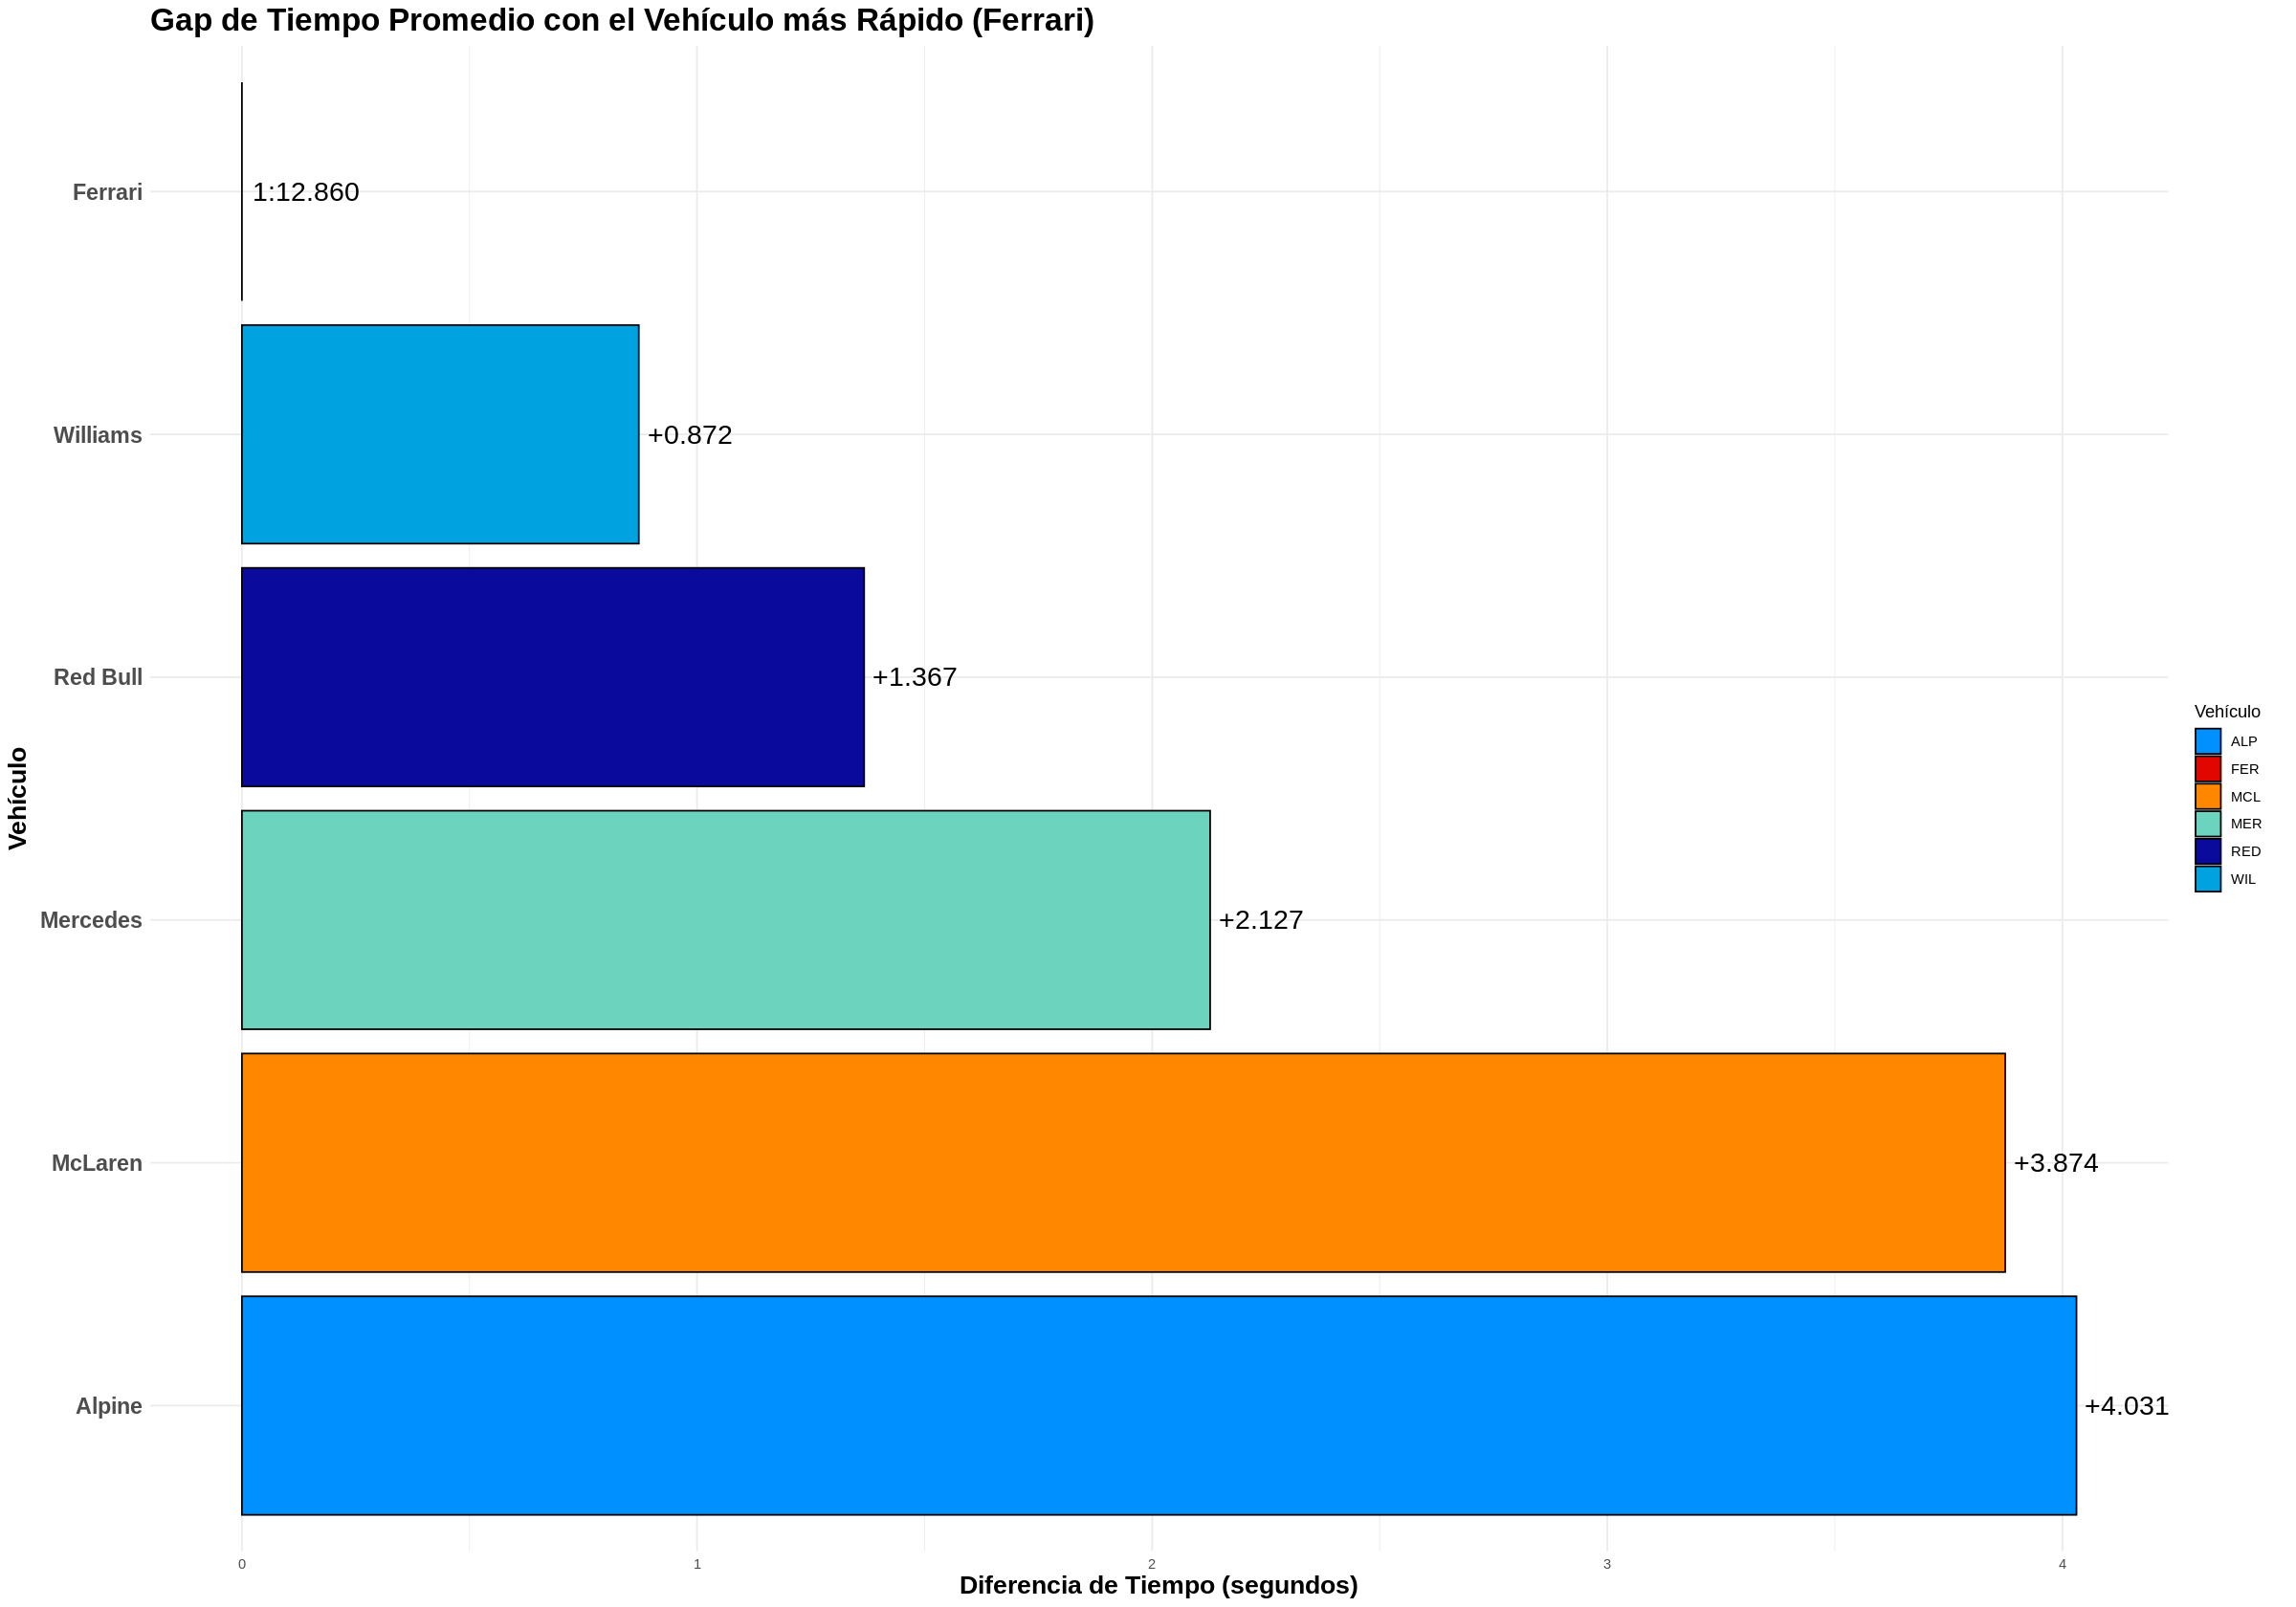

In [97]:
format_time_ms <- function(seconds) {
  minutes <- floor(seconds / 60)
  remaining_seconds <- seconds %% 60
  sprintf("%d:%06.3f", minutes, remaining_seconds)
}

# Calculate average lap time for each carId
average_lap_times <- telemetria %>%
  # Removed: filter(lap_time_invalid == 0) %>% # Filter out invalid lap times
  group_by(carId, lap_number) %>%
  summarise(total_lap_time = max(lap_time, na.rm = TRUE), .groups = 'drop') %>%
  group_by(carId) %>%
  summarise(avg_lap_time = mean(total_lap_time, na.rm = TRUE), .groups = 'drop')

# Identify the fastest vehicle
fastest_car_time <- min(average_lap_times$avg_lap_time, na.rm = TRUE)
fastest_car_id_abb <- average_lap_times %>%
  filter(avg_lap_time == fastest_car_time) %>%
  pull(carId) %>% head(1) # Get abbreviation for fastest car

# Define custom bright team colors (colores_f1)
colores_f1 <- c(
  "FER" = "#E10600",  # Ferrari Red
  "RED" = "#0A0A9C",  # Red Bull Navy Blue
  "MCL" = "#FF8700",  # McLaren Papaya Orange
  "MER" = "#6CD3BF",  # Mercedes Teal
  "ALP" = "#0090FF",  # Alpine Blue
  "WIL" = "#00A3E0"   # Williams Light Blue
)

# Create a mapping for full team names
full_team_names <- c(
  "FER" = "Ferrari",
  "RED" = "Red Bull",
  "MCL" = "McLaren",
  "MER" = "Mercedes",
  "ALP" = "Alpine",
  "WIL" = "Williams"
)

# Calculate the gap for each vehicle relative to the fastest
gap_data <- average_lap_times %>%
  mutate(gap_seconds = avg_lap_time - fastest_car_time) %>%
  mutate(full_carId = recode(carId, !!!full_team_names)) %>%
  arrange(gap_seconds) # Order by gap_seconds for plotting

# Get the full name and formatted time of the fastest car for the title and annotation
fastest_car_full_name <- full_team_names[fastest_car_id_abb]
fastest_car_time_formatted <- format_time_ms(fastest_car_time)

# Prepare labels: replace 0 gap with formatted fastest time, add '+' for others
gap_data <- gap_data %>%
  mutate(display_label = ifelse(gap_seconds == 0,
                                fastest_car_time_formatted,
                                paste0("+", as.character(round(gap_seconds, 3)))))

# Create the horizontal bar chart
ggplot(gap_data, aes(x = gap_seconds, y = reorder(full_carId, -gap_seconds), fill = carId)) +
  geom_bar(stat = "identity", color = "black") +
  geom_text(aes(label = display_label), hjust = -0.1, size = 6) + # Use display_label
  scale_fill_manual(values = colores_f1) +
  labs(
    title = paste0("Gap de Tiempo Promedio con el Vehículo más Rápido (", fastest_car_full_name, ")"),
    x = "Diferencia de Tiempo (segundos)",
    y = "Vehículo",
    fill = "Vehículo"
  ) +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 14, face = "bold"), # Enlarge and bold y-axis text
    axis.title.x = element_text(size = 16, face = "bold"), # Enlarge and bold x-axis title
    axis.title.y = element_text(size = 16, face = "bold"), # Enlarge and bold y-axis title
    plot.title = element_text(size = 20, face = "bold") # Enlarge and bold plot title
  )


### Gap de Tiempo Promedio con el Vehículo más Rápido

In [109]:
display_gap_data <- gap_data %>%
  select(full_carId, avg_lap_time, gap_seconds, display_label) %>%
  arrange(gap_seconds)

print(display_gap_data)

# A tibble: 6 × 4
  full_carId avg_lap_time gap_seconds display_label
  <chr>             <dbl>       <dbl> <chr>        
1 Ferrari            72.9       0     1:12.860     
2 Williams           73.7       0.872 +0.872       
3 Red Bull           74.2       1.37  +1.367       
4 Mercedes           75.0       2.13  +2.127       
5 McLaren            76.7       3.87  +3.874       
6 Alpine             76.9       4.03  +4.031       


Como podemos observar en el grafico anterior, podemos definir que el auto mas rápido fue el de la escudería Ferrari(en un tiempo de 1:12:86) , seguido de Williams llegando en segundo lugar (0,872 segundos después), para cerrar el podio estaría el equipo de Red-Bull (a 1,367 segundos respecto al primero), en cuarta posición Mercedes (a 2,127 segundos), quinto el equipo de McLaren (a 3,874 segundos) y en ultimo lugar el equipo de Alpine (a 4,031 segundos del equipo de Ferrari)

 # Actividad 10 (Grafico 8)

 Elabore un gráfico que muestre la velocidad máxima para cada uno de los vehículos, ordenado desde el más rápido al más lento SOLO TENIENDO EN CUENTA LAS VUELTAS VALIDAS. En el eje de las abscisas (X), se representarán los vehículos, mientras que en el eje de las ordenadas (Y) se plasmará la velocidad máxima por cada vehículo.

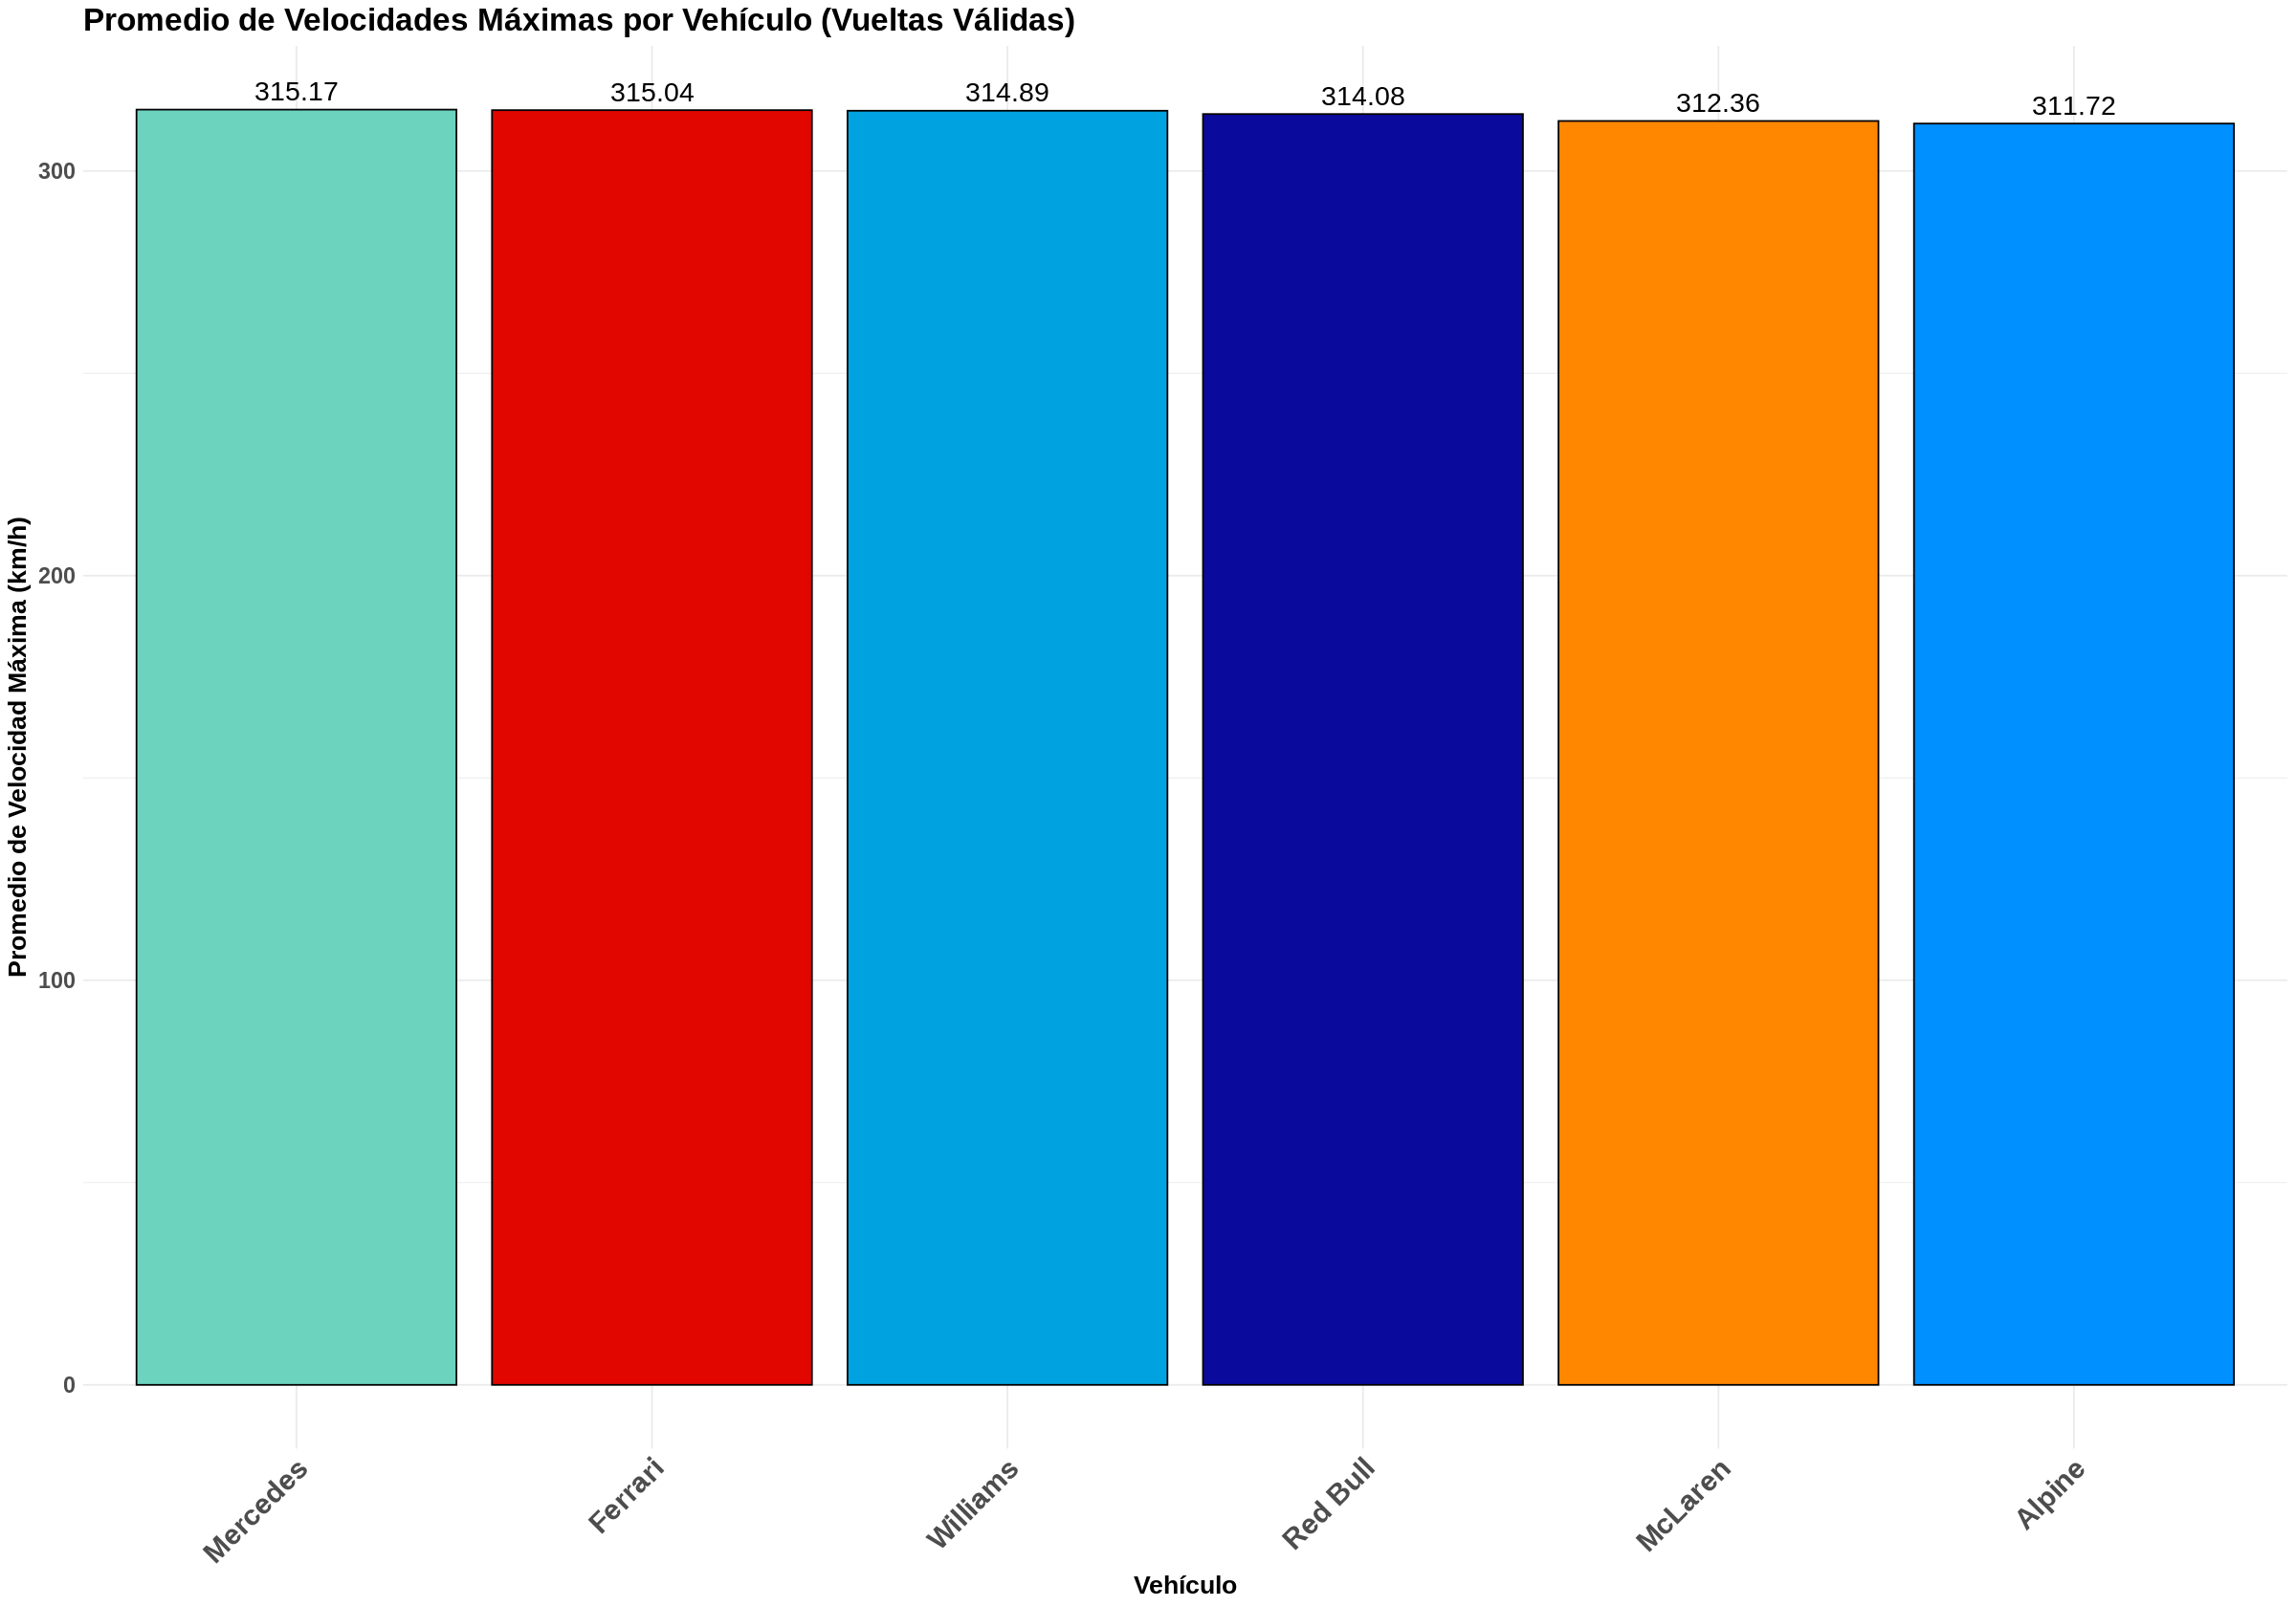

In [105]:
# Calculate the average of maximum velocities for each car, considering only valid laps
avg_max_velocity_data <- telemetria %>%
  filter(lap_time_invalid == 0) %>% # Filter for valid laps only
  group_by(carId, lap_number) %>% # Group by car and lap to find max vel per lap
  summarise(max_vel_per_lap = max(velocidad, na.rm = TRUE), .groups = 'drop') %>%
  group_by(carId) %>% # Now group by car to average the max vels per lap
  summarise(avg_max_velocidad = mean(max_vel_per_lap, na.rm = TRUE), .groups = 'drop') %>%
  arrange(desc(avg_max_velocidad)) # Order from fastest to slowest average max vel

# Define custom bright team colors (colores_f1)
colores_f1 <- c(
  "FER" = "#E10600",  # Ferrari Red
  "RED" = "#0A0A9C",  # Red Bull Navy Blue
  "MCL" = "#FF8700",  # McLaren Papaya Orange
  "MER" = "#6CD3BF",  # Mercedes Teal
  "ALP" = "#0090FF",  # Alpine Blue
  "WIL" = "#00A3E0"   # Williams Light Blue
)

# Create a mapping for full team names
full_team_names <- c(
  "FER" = "Ferrari",
  "RED" = "Red Bull",
  "MCL" = "McLaren",
  "MER" = "Mercedes",
  "ALP" = "Alpine",
  "WIL" = "Williams"
)

# Add full team names to the data and create an ordered factor for plotting
avg_max_velocity_data <- avg_max_velocity_data %>%
  mutate(full_carId = recode(carId, !!!full_team_names)) %>%
  mutate(full_carId = factor(full_carId, levels = unique(full_carId[order(-avg_max_velocidad)]))) # Create ordered factor

# Create the bar chart for average maximum velocity
ggplot(avg_max_velocity_data, aes(x = full_carId, y = avg_max_velocidad, fill = carId)) +
  geom_col(color = "black") +
  geom_text(aes(label = round(avg_max_velocidad, 2)), vjust = -0.5, size = 6) + # Display values on top of bars
  scale_fill_manual(values = colores_f1) +
  labs(
    title = "Promedio de Velocidades Máximas por Vehículo (Vueltas Válidas)", # Updated title
    x = "Vehículo",
    y = "Promedio de Velocidad Máxima (km/h)", # Updated y-axis label
    fill = "Vehículo"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 18, face = "bold"), # Increased x-axis text size
    axis.text.y = element_text(size = 14, face = "bold"), # Enlarge and bold y-axis text
    axis.title.x = element_text(size = 16, face = "bold"), # Enlarge and bold x-axis title
    axis.title.y = element_text(size = 16, face = "bold"), # Enlarge and bold y-axis title
    plot.title = element_text(size = 20, face = "bold"), # Enlarge and bold plot title
    legend.position = "none"
  )

### Cuadro 2: Promedio de Velocidades Máximas por Vehículo

In [108]:
print(avg_max_velocity_data)

# A tibble: 6 × 3
  carId avg_max_velocidad full_carId
  <chr>             <dbl> <fct>     
1 MER                315. Mercedes  
2 FER                315. Ferrari   
3 WIL                315. Williams  
4 RED                314. Red Bull  
5 MCL                312. McLaren   
6 ALP                312. Alpine    
